In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors

from itertools import combinations, permutations
import scipy
from scipy.ndimage.filters import gaussian_filter1d
import sys
import os
import copy
atish_assay_path = 'fitness_assay_grantedits.py'
sys.path.append(os.path.dirname(os.path.expanduser(atish_assay_path)))
import fitness_assay_grantedits as atish

tools_path = '../code/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools

sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()
from tools import mutant_colorset

In [2]:
merged_name = 'noF_DoubleBC_merged+flaskswapcorrected_052019' 
unmerged_name = 'noF_DoubleBC_flaskswapcorrected_052019'

merged_data = p.read_csv(f'../data/BarcodeCounts_{merged_name}_withBCinfo.csv')
unmerged_data = p.read_csv(f'../data/BarcodeCounts_{unmerged_name}_withBCinfo.csv')

bad_samples = ['B.DE1.PCRb.3']

cov_thresh = 1e6
n_resamples = 50

In [3]:
old_conditions = {
                  '3':['3.1','3.2','3.3'],
                  '6':['6.1','6.2','6.3'],
                  '13':['13.1','13.2','13.3'],
                  '18':['18.1','18.2','18.3'],
                  '20':['20.1','20.2','20.3'],
                  '21':['21.1','21.2','21.3'],
                  '23':['23.1','23.2','23.3']
                 }

bigbatch_conditions = {
                        '1BB_M3':['A','B','C','D'],
                        '1BB_Baffle':['E','F'],
                        '1BB_1.4%Gluc' :['G','H'],
                        '1BB_1.8%Gluc' :['I','J'],
                        '1BB_0.2MNaCl' :['K','L'],
#                         '1BB_0.5MNaCl' :['M','N'],
#                         '1BB_0.2MNaCl' :['K'], 
                        '1BB_0.2MKCl' :['O'],
                        '1BB_0.5MKCl' :['P'],
#                         '1BB_8.5uMGdA' :['Q','R'],
#                         '1BB_17uMGdA' :['S','T'],
#                         '1BB_2ugFlu' :['U','V'],
#                         '1BB_0.5ugFlu' :['W','X'],
                        '1BB_1%Raf' :['Y','Z'],
                        '1BB_0.5%Raf' :['AA','BB'],
                        '1BB_1%Gly' :['CC','DD'],
#                         '1BB_1%EtOH' :['EE','FF'],
#                         '1BB_SucRaf' :['GG'],
                      }



conditions = {**old_conditions, **bigbatch_conditions}

just_reps = [rep for reps in conditions.values() for rep in reps]

In [5]:
### TECHNICAL REPLICATES

data = unmerged_data
data = data[~(data['barcode'].isin([7777777,9999999]))]
data = data.replace([np.inf, -np.inf], np.nan)
data = data.sort_values('barcode')

full_neutral_list = [17615,18486,42040,45014,58284,63611,73731,74185,80465,94896
,120600,125697,132511,134852,135750,190551,228237,238783,255561,298344
,308537,316954,317346,335717,411685,454359,469053] 

### from previous list but never has fitness above 3.5% (per gen) in any of 5000bc experiments
supergood_neutral = [17615, 24362, 42040, 71926, 72939, 73802, 80465, 109476, 113483, 
                     134852, 135750, 238783, 263665, 276406, 316954, 335717, 454359] 

### pulled from supergood list and spiked into 1BigBatch experiments
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]

# neutrals = full_neutral_list
neutrals = list(np.unique(full_neutral_list+supergood_neutral+neutral_spikes))
neutrals = [bc for bc in neutrals if bc in data['barcode'].values]

technical_conditions = {'A':["A.DE1.PCRa","A.DE1.PCRb"],
                       'B':["B.DE1.PCRa","B.DE1.PCRb","B.DE1.PCRc","B.DE2.PCRa","B.DE3.PCRa", "B.DE4.PCRa"],
                       'C':["C.DE1.PCRa","C.DE1.PCRb","C.DE2.PCRa", "C.DE1.PCRc", "C.DE3.PCRa","C.DE3.PCRb"],
                       'D':["D.DE1.PCRa","D.DE1.PCRb"]}
        
fitnesses = {} 
for t in range(5):
    for condition in technical_conditions:
        for pair in np.unique(np.asarray(list(permutations(technical_conditions[condition]*2,2))),axis=0):
            
            flask1,de1,pcr1 = pair[0].split('.')
            flask2,de2,pcr2 = pair[1].split('.')
            
            t0 = f'{flask1}{t}-{de1}-{pcr1}'
            t1 = f'{flask2}{t}-{de2}-{pcr2}'
            
            if ((t0 in data.columns) and (t1 in data.columns)) and not ((t0 in bad_samples) or t1 in bad_samples):

                these_times = [t0,t1]
                timepoints = [t,t+1]
                
                if np.all(np.sum(data[these_times].values,axis=0)>cov_thresh):
    
#                     answer = atish.inferFitness(data['barcode'].values,timepoints,{'rep1':data[these_times].values},neutralBarcodes=neutrals,
#                                                 lowCoverageThresh=cov_thresh,use_all_neutral=True,weightedMean=False)

#                     fitnesses[f'{pair[0]}.{t}-{pair[1]}.{t+1}_original'+'_fitness'] = answer['rep1']['aveFitness']
#                     fitnesses[f'{pair[0]}.{t}-{pair[1]}.{t+1}_original'+'_error'] = answer['rep1']['aveError']
                    fitnesses['barcode'] = data['barcode'].values
                    
                    t0_data = data[t0].values
                    t1_data = data[t1].values

                    
                    down_samples = [tools.downsample_single(np.asarray([t0_data,t1_data]).swapaxes(0,1),cov_thresh) for i in range(n_resamples)]

                    for sample in range(n_resamples):
#                         timepoints = [t,t+1]

                        answer = atish.inferFitness(data['barcode'].values,timepoints,{'rep1':down_samples[sample]},neutralBarcodes=neutrals,
                                                        lowCoverageThresh=1,use_all_neutral=True,weightedMean=False)

                        fitnesses[f'flat{pair[0]}.{t}-{pair[1]}.{t}_resample{int(cov_thresh)}_{sample}'+'_fitness'] = answer['rep1']['aveFitness']

flat_technical_fitness_df = p.DataFrame(fitnesses)

2
neutral reads 15997.0 16031.0
neutral reads 15997.0 16031.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.88638004]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16200.0 15849.0
neutral reads 16200.0 15849.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.63338106]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16043.0 16182.0
neutral reads 16043.0 16182.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.2207332]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16042.0 15836.0
neutral reads 16042.0 15836.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.11064615]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15848.0 16159.0
neutral reads 15848.0 16159.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.73373622]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16261.0 16098.0
neutral r

/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:219: RuntimeWarning: divide by zero encountered in power
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:219: RuntimeWarning: invalid value encountered in multiply
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:386: RuntimeWarning: divide by zero encountered in log
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:386: RuntimeWarning: invalid value encountered in subtract
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_a

neutral reads 16148.0 17346.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.96229857]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16303.0 17367.0
neutral reads 13918.0 14339.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.22232096]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15985.0 17402.0
neutral reads 15985.0 17402.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [12.11102613]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16325.0 17463.0
neutral reads 16325.0 17463.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.03644815]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16070.0 17448.0
neutral reads 16070.0 17448.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [12.59950805]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16016.0 17513.0
neutral reads 16016.0 17513.0
Multipli

2
neutral reads 17421.0 15952.0
neutral reads 17421.0 15952.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.4762122]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17565.0 15951.0
neutral reads 17565.0 15951.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [15.3158401]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17293.0 16120.0
neutral reads 17293.0 16120.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.80310701]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17400.0 16147.0
neutral reads 17400.0 16147.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.17852273]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17396.0 15996.0
neutral reads 17396.0 15996.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.14458671]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17059.0 16042.0
neutral r

2
neutral reads 17437.0 17338.0
neutral reads 17437.0 17338.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.8861154]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17380.0 17064.0
neutral reads 17380.0 17064.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.30823341]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17387.0 17387.0
neutral reads 17387.0 17387.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.0566086]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17284.0 17232.0
neutral reads 17284.0 17232.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.7982783]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17379.0 17344.0
neutral reads 17371.0 17324.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.0739499]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17384.0 17433.0
neutral read

No clear inconsistencies

2
neutral reads 9554.0 9808.0
neutral reads 9554.0 9808.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.49989163]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9653.0 9550.0
neutral reads 9653.0 9550.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.23364498]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9608.0 9578.0
neutral reads 9608.0 9578.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.8409983]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9614.0 9653.0
neutral reads 9614.0 9653.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.25783788]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9626.0 9725.0
neutral reads 9626.0 9725.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.83309496]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9536.0 9593.0
neutr

2
neutral reads 10137.0 9411.0
neutral reads 10137.0 9411.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.37899028]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10176.0 9629.0
neutral reads 10176.0 9629.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [10.82260635]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10029.0 9613.0
neutral reads 10029.0 9613.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.25375732]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10178.0 9621.0
neutral reads 10178.0 9621.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.26056446]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10025.0 9537.0
neutral reads 10025.0 9537.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.15564099]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10380.0 9622.0
neutral reads 1038

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.72062898]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10177.0 10099.0
neutral reads 10177.0 10099.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.02476525]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10000.0 10196.0
neutral reads 10000.0 10196.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.85211963]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10043.0 9983.0
neutral reads 10043.0 9983.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.31885001]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10084.0 10185.0
neutral reads 10084.0 10185.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.11491512]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9985.0 9847.0
neutral reads 9985.0 9847.0
Multiplicative noise consistency checks

rep1 

neutral reads 10410.0 10111.0
neutral reads 10410.0 10111.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.31625602]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10094.0 10208.0
neutral reads 10094.0 10208.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.92997576]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10160.0 10223.0
neutral reads 10160.0 10223.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.37323132]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10196.0 10303.0
neutral reads 10196.0 10303.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.67922944]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10199.0 10162.0
neutral reads 10199.0 10162.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.56097185]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10242.0 10282.0
neutral re

2
neutral reads 10106.0 9959.0
neutral reads 10106.0 9959.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.35520993]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9797.0 9909.0
neutral reads 9797.0 9909.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.72312393]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10009.0 9839.0
neutral reads 10009.0 9839.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.81348051]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9995.0 10004.0
neutral reads 9995.0 10004.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.45899343]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9880.0 10034.0
neutral reads 9880.0 10034.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.08596824]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10029.0 9962.0
neutral reads 10029.0

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.06286953]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10094.0 10022.0
neutral reads 10094.0 10022.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.56931639]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9977.0 9998.0
neutral reads 9977.0 9998.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.59552187]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10037.0 9780.0
neutral reads 10037.0 9780.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.0559044]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10032.0 9986.0
neutral reads 10032.0 9986.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.27242316]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10112.0 9942.0
neutral reads 10112.0 9942.0
Multiplicative noise consistency checks

rep1  inco

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [14.18005819]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8893.0 9812.0
neutral reads 8893.0 9812.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [10.34638258]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9043.0 10291.0
neutral reads 9043.0 10291.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.37405613]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8825.0 9885.0
neutral reads 8825.0 9885.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [11.96365619]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8956.0 9990.0
neutral reads 8956.0 9990.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [13.83278142]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8857.0 10093.0
neutral reads 8857.0 10093.0
Multiplicative noise consistency checks

rep1  incon

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [17.20993285]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8957.0 9639.0
neutral reads 8957.0 9639.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [25.25620291]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8964.0 9651.0
neutral reads 8964.0 9651.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [18.96175079]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8961.0 10008.0
neutral reads 8961.0 10008.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [29.68510735]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8924.0 9848.0
neutral reads 8924.0 9848.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [17.11670243]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8943.0 9878.0
neutral reads 8943.0 9878.0
Multiplicative noise consistency checks

rep1  incons

2
neutral reads 9900.0 9111.0
neutral reads 9900.0 9111.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [15.96439351]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9765.0 9050.0
neutral reads 9765.0 9050.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [22.55175235]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9924.0 9116.0
neutral reads 9924.0 9116.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [19.87197871]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9945.0 9043.0
neutral reads 9945.0 9043.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [16.64365739]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10012.0 9085.0
neutral reads 10012.0 9085.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [24.83746767]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10046.0 8841.0
neutral reads 10046.0 

neutral reads 10065.0 9677.0
neutral reads 10065.0 9677.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.16340473]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9933.0 9959.0
neutral reads 9933.0 9959.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.66379739]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9986.0 10034.0
neutral reads 9986.0 10034.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.31641465]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9785.0 9803.0
neutral reads 9785.0 9803.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.39338287]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9942.0 9860.0
neutral reads 9942.0 9860.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.99795659]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10079.0 10060.0
neutral reads 10079.0 1006

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.31773217]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10561.0 10691.0
neutral reads 10561.0 10691.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.80433431]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10655.0 10609.0
neutral reads 10655.0 10609.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.41742351]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10436.0 10566.0
neutral reads 10436.0 10566.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.05386669]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10798.0 10375.0
neutral reads 10798.0 10375.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.02044329]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10607.0 10434.0
neutral reads 10607.0 10434.0
Multiplicative noise consistency checks


2
neutral reads 10459.0 10652.0
neutral reads 10459.0 10652.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.34147706]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10276.0 10707.0
neutral reads 10276.0 10707.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.97596696]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10338.0 10435.0
neutral reads 10338.0 10435.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.62006526]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10369.0 10652.0
neutral reads 10369.0 10652.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.64454475]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10562.0 10541.0
neutral reads 10562.0 10541.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.69622342]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10449.0 10691.0
neutral 

neutral reads 10383.0 10542.0
neutral reads 10383.0 10542.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.34266346]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10506.0 10521.0
neutral reads 10506.0 10521.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.02173952]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10381.0 10515.0
neutral reads 10381.0 10515.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.03086739]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10571.0 10439.0
neutral reads 10571.0 10439.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.59299925]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10356.0 10281.0
neutral reads 10356.0 10281.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.33274946]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10755.0 10709.0
neutral re

neutral reads 5009.0 4775.0
neutral reads 5009.0 4775.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.23042806]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4944.0 4916.0
neutral reads 4943.0 4910.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.38352134]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4892.0 4889.0
neutral reads 4892.0 4889.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.13348564]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4869.0 4907.0
neutral reads 4869.0 4907.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.61682483]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4878.0 5008.0
neutral reads 4878.0 5008.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.05222671]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4891.0 4886.0
neutral reads 4891.0 4886.0
Mult

neutral reads 4934.0 4951.0
neutral reads 4934.0 4951.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.42118386]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4845.0 5061.0
neutral reads 4845.0 5056.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.58312061]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4936.0 4981.0
neutral reads 4936.0 4981.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.03912187]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4935.0 5015.0
neutral reads 4935.0 5015.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.53972038]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4948.0 5076.0
neutral reads 4948.0 5076.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.16006274]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4882.0 5159.0
neutral reads 4882.0 5159.0
Mult

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.8973218]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5216.0 4954.0
neutral reads 5216.0 4954.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.25799789]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4968.0 5057.0
neutral reads 4968.0 5057.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.9431]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4922.0 5031.0
neutral reads 4922.0 5031.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.16655425]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4936.0 5050.0
neutral reads 4936.0 5050.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.28025081]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4974.0 4993.0
neutral reads 4974.0 4993.0
Multiplicative noise consistency checks

rep1  inconsistent times

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.98064749]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4758.0 4755.0
neutral reads 4758.0 4750.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.89573587]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4830.0 4721.0
neutral reads 4830.0 4721.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.41242363]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4854.0 4735.0
neutral reads 4854.0 4735.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.55098255]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4901.0 4730.0
neutral reads 4901.0 4730.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.18371153]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4925.0 4823.0
neutral reads 4925.0 4823.0
Multiplicative noise consistency checks

rep1  inconsistent 

No clear inconsistencies

2
neutral reads 4950.0 5097.0
neutral reads 4950.0 5097.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.58708877]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4802.0 5002.0
neutral reads 4802.0 5002.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [11.29719365]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4809.0 5073.0
neutral reads 4809.0 5073.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.83243412]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4906.0 5074.0
neutral reads 4906.0 5074.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.51540611]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4795.0 5129.0
neutral reads 4795.0 5129.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.07119045]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4880.0 5078.0
neu

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.35593538]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4900.0 4547.0
neutral reads 4900.0 4547.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.87806679]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4826.0 4507.0
neutral reads 4826.0 4507.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.79774685]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4918.0 4540.0
neutral reads 4918.0 4540.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.22321608]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4879.0 4562.0
neutral reads 4879.0 4562.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.70045729]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4864.0 4503.0
neutral reads 4864.0 4503.0
Multiplicative noise consistency checks

rep1  inconsistent 

neutral reads 5014.0 4722.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.35010858]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5076.0 4703.0
neutral reads 5076.0 4703.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.07437965]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5057.0 4873.0
neutral reads 5057.0 4873.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.03264745]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5138.0 4852.0
neutral reads 5138.0 4852.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.10145264]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5004.0 4742.0
neutral reads 5004.0 4742.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.61332237]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4977.0 4856.0
neutral reads 4977.0 4856.0
Multiplicative noise consistency

2
neutral reads 5148.0 4506.0
neutral reads 5148.0 4506.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.12170618]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5055.0 4516.0
neutral reads 5055.0 4516.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.14381103]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5094.0 4467.0
neutral reads 5094.0 4467.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.1291278]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5244.0 4708.0
neutral reads 5244.0 4708.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.74589926]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5117.0 4588.0
neutral reads 5117.0 4588.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.92256321]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5114.0 4591.0
neutral reads 5114.0 4591.0
Mul

2
neutral reads 5000.0 4395.0
neutral reads 5000.0 4395.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.13553323]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5093.0 4455.0
neutral reads 5093.0 4455.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.69600152]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5038.0 4471.0
neutral reads 5038.0 4471.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.44830923]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5089.0 4489.0
neutral reads 5089.0 4489.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.86093314]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5048.0 4540.0
neutral reads 5048.0 4540.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.27983056]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5054.0 4551.0
neutral reads 5054.0 4551.0
Mu

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.64936256]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5064.0 4537.0
neutral reads 5064.0 4537.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.90499443]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5032.0 4665.0
neutral reads 5032.0 4665.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.10919563]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5135.0 4556.0
neutral reads 5135.0 4556.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.46714706]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5005.0 4466.0
neutral reads 5005.0 4466.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.78226916]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4586.0 4796.0
neutral reads 4586.0 4796.0
Multiplicative noise consistency checks

rep1  inconsistent 

rep1  inconsistent times:

kappas [4.41314117]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4543.0 5032.0
neutral reads 4543.0 5032.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [13.73834161]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4477.0 5169.0
neutral reads 4477.0 5169.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.10289199]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4614.0 5126.0
neutral reads 4614.0 5126.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.51680644]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4504.0 5037.0
neutral reads 4504.0 5037.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [10.79959203]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4566.0 5003.0
neutral reads 4566.0 5003.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.94155264]
multNoise [

neutral reads 4586.0 4473.0
neutral reads 4586.0 4473.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.60057177]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4549.0 4538.0
neutral reads 4549.0 4538.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.09276915]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4575.0 4451.0
neutral reads 4575.0 4451.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.75443636]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4578.0 4609.0
neutral reads 4578.0 4609.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.23411]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4535.0 4594.0
neutral reads 4535.0 4594.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.45498692]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4539.0 4476.0
neutral reads 4539.0 4476.0
Multipl

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.38697129]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4598.0 4540.0
neutral reads 4598.0 4540.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.41396063]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4574.0 4378.0
neutral reads 4574.0 4378.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.36776497]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4451.0 4514.0
neutral reads 4451.0 4514.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.02036406]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4593.0 4526.0
neutral reads 4593.0 4526.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.70788613]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4518.0 4464.0
neutral reads 4518.0 4464.0
Multiplicative noise consistency checks

rep1  inconsistent 

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.37747112]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4646.0 4884.0
neutral reads 4422.0 4562.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.81791497]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4441.0 4806.0
neutral reads 4441.0 4806.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.11225035]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4540.0 4776.0
neutral reads 4540.0 4776.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.88391582]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4459.0 4812.0
neutral reads 4459.0 4812.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.94123845]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4492.0 4826.0
neutral reads 4294.0 4503.0
Multiplicative noise consistency checks

rep1  inconsistent 

kappas [6.6592485]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4450.0 4964.0
neutral reads 4450.0 4964.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.57531249]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4539.0 5131.0
neutral reads 4539.0 5131.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.81940306]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4514.0 5025.0
neutral reads 4514.0 5025.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.62791357]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4452.0 4474.0
neutral reads 4452.0 4474.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.48652527]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4495.0 4473.0
neutral reads 4495.0 4473.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.72693824]
multNoise [0.1]
No clear inconsistencies


Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.99933116]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4469.0 4556.0
neutral reads 4469.0 4556.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.32512006]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4495.0 4538.0
neutral reads 4495.0 4538.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.93493468]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4407.0 4531.0
neutral reads 4407.0 4525.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.83537541]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4578.0 4521.0
neutral reads 4578.0 4521.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.52701541]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4376.0 4583.0
neutral reads 4376.0 4583.0
Multiplicative noise consistency checks

rep1  inconsistent 

neutral reads 5343.0 5372.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.63323997]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5436.0 5467.0
neutral reads 5436.0 5467.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.45485412]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5518.0 5339.0
neutral reads 5518.0 5339.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.5542958]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5236.0 5510.0
neutral reads 5236.0 5510.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.1190416]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5374.0 5360.0
neutral reads 5374.0 5355.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.74330073]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5468.0 5551.0
neutral reads 5468.0 5551.0
Multiplicative noise consistency c

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.72597311]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5372.0 5388.0
neutral reads 5372.0 5388.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.5882761]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5421.0 5434.0
neutral reads 5421.0 5434.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.83560426]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5541.0 5399.0
neutral reads 5541.0 5399.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.37571074]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5285.0 5430.0
neutral reads 5285.0 5429.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.33007126]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5505.0 5433.0
neutral reads 5505.0 5433.0
Multiplicative noise consistency checks

rep1  inconsistent t

No clear inconsistencies

2
neutral reads 5389.0 5529.0
neutral reads 5389.0 5529.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.57699046]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5428.0 5382.0
neutral reads 5427.0 5376.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.09274973]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5202.0 5256.0
neutral reads 5202.0 5254.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.93361161]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5376.0 5354.0
neutral reads 5376.0 5354.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.27847731]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5366.0 5343.0
neutral reads 5366.0 5343.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.84327281]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5344.0 5353.0
neut

neutral reads 5273.0 5277.0
neutral reads 5273.0 5277.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [10.89900027]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5273.0 5253.0
neutral reads 5273.0 5244.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [13.06263116]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5165.0 5143.0
neutral reads 5165.0 5143.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [19.57770891]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5291.0 5265.0
neutral reads 5291.0 5262.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [14.49600792]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5193.0 5136.0
neutral reads 5193.0 5136.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [17.46349439]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5146.0 5182.0
neutral reads 5146.0 5182.0

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.66873532]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5288.0 5190.0
neutral reads 5288.0 5190.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.99954319]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5236.0 5181.0
neutral reads 5236.0 5181.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.82053711]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5232.0 5366.0
neutral reads 5232.0 5366.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.26741036]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5330.0 5020.0
neutral reads 5330.0 5020.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.36807589]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5139.0 5254.0
neutral reads 5139.0 5254.0
Multiplicative noise consistency checks

rep1  inconsistent 

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.8646525]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1975.0 2013.0
neutral reads 1975.0 2013.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.13070564]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1965.0 1932.0
neutral reads 1965.0 1932.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.86925857]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1980.0 2038.0
neutral reads 1980.0 2038.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.90772095]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1959.0 2024.0
neutral reads 1959.0 2024.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.50449952]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1960.0 1977.0
neutral reads 1960.0 1977.0
Multiplicative noise consistency checks

rep1  inconsistent t

neutral reads 1957.0 2005.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.52991223]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2012.0 2129.0
neutral reads 2012.0 2129.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.83802479]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1979.0 2044.0
neutral reads 1979.0 2044.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.07563112]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2042.0 2043.0
neutral reads 2042.0 2043.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.65003782]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2109.0 1973.0
neutral reads 2109.0 1973.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.06324126]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2082.0 1977.0
neutral reads 2082.0 1975.0
Multiplicative noise consistency

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.58619154]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2015.0 2005.0
neutral reads 2015.0 2005.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.70648133]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2203.0 2010.0
neutral reads 2203.0 2010.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.26486814]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2162.0 1969.0
neutral reads 2162.0 1969.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.8024885]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2092.0 1995.0
neutral reads 2092.0 1995.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.01477151]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2093.0 2011.0
neutral reads 2093.0 2011.0
Multiplicative noise consistency checks

rep1  inconsistent t

neutral reads 2802.0 2891.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.10221106]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2847.0 2838.0
neutral reads 2847.0 2836.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.06624635]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2857.0 2751.0
neutral reads 2857.0 2751.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.26761736]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2814.0 2830.0
neutral reads 2814.0 2829.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.61309754]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2833.0 2728.0
neutral reads 2833.0 2728.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.34828182]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2889.0 2818.0
neutral reads 2889.0 2817.0
Multiplicative noise consistency

2
neutral reads 972.0 951.0
neutral reads 972.0 951.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.05015756]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 991.0 911.0
neutral reads 991.0 911.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.56826237]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 904.0 990.0
neutral reads 904.0 990.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.66677043]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 947.0 958.0
neutral reads 947.0 958.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.53543644]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 958.0 943.0
neutral reads 958.0 943.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.51353653]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 894.0 880.0
neutral reads 894.0 880.0
Multiplicative noise consi

neutral reads 898.0 958.0
neutral reads 898.0 958.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.27769542]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 946.0 898.0
neutral reads 946.0 898.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.44380448]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 998.0 1063.0
neutral reads 998.0 1062.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.44203375]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 968.0 1109.0
neutral reads 968.0 1107.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.73790257]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 945.0 1164.0
neutral reads 945.0 1162.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.02761275]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 956.0 1076.0
neutral reads 956.0 1073.0
Multiplicative noise

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.28844587]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1100.0 967.0
neutral reads 1100.0 967.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.00794703]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1061.0 925.0
neutral reads 1061.0 925.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.45436355]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1046.0 909.0
neutral reads 1046.0 909.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.73910495]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1080.0 902.0
neutral reads 1080.0 902.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.4211612]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1070.0 980.0
neutral reads 1070.0 980.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kap

2
neutral reads 1063.0 1101.0
neutral reads 1063.0 1101.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.67278009]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1086.0 1055.0
neutral reads 1086.0 1055.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.85008258]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1069.0 1040.0
neutral reads 1069.0 1040.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.96735417]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1064.0 1103.0
neutral reads 1064.0 1103.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.76729694]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1072.0 1109.0
neutral reads 1040.0 1044.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.91423995]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1035.0 1096.0
neutral reads 1035.0 1096.0
Mu


kappas [0.79369254]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1030.0 1018.0
neutral reads 1030.0 1018.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.39771203]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 942.0 983.0
neutral reads 942.0 983.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.18180495]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1002.0 1018.0
neutral reads 1002.0 1018.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.93167446]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 967.0 1023.0
neutral reads 967.0 1023.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.91705063]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1048.0 1015.0
neutral reads 1048.0 1015.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.14795659]
multNoise [0.1]
No clear inconsistencies

2
n

neutral reads 969.0 974.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.82981119]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 979.0 976.0
neutral reads 979.0 976.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.55850854]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1014.0 1038.0
neutral reads 1014.0 1038.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.33615466]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1059.0 1012.0
neutral reads 1059.0 1012.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.96798704]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1055.0 996.0
neutral reads 1055.0 996.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.00722351]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1023.0 1025.0
neutral reads 1023.0 1025.0
Multiplicative noise consistency checks


Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.91054747]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 980.0 1042.0
neutral reads 980.0 1041.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.96190758]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1015.0 1065.0
neutral reads 1015.0 1064.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.29783888]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 990.0 1057.0
neutral reads 990.0 1057.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.98579451]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 988.0 1016.0
neutral reads 988.0 1016.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.34242929]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 982.0 1074.0
neutral reads 982.0 1074.0
Multiplicative noise consistency checks

rep1  inconsistent times:



neutral reads 1047.0 949.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.94501421]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1008.0 933.0
neutral reads 1008.0 933.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.9452215]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 991.0 1000.0
neutral reads 991.0 1000.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.43175107]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 974.0 960.0
neutral reads 974.0 960.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.03208998]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1027.0 929.0
neutral reads 1027.0 929.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.5036084]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 992.0 934.0
neutral reads 992.0 934.0
Multiplicative noise consistency checks

rep1  in

kappas [0.74362327]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 987.0 1058.0
neutral reads 987.0 1058.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.07373242]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 960.0 990.0
neutral reads 960.0 990.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.3258502]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 950.0 1024.0
neutral reads 950.0 1024.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.32900571]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1060.0 1029.0
neutral reads 1060.0 1029.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.19208378]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 934.0 996.0
neutral reads 934.0 996.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.59864153]
multNoise [0.1]
No clear inconsistencies

2
neutral r

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.78420078]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 953.0 1034.0
neutral reads 953.0 1033.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.47809147]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 976.0 1032.0
neutral reads 976.0 1029.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.94596508]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1022.0 1077.0
neutral reads 1022.0 1077.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.07469428]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 961.0 1044.0
neutral reads 961.0 1044.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.07851211]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 938.0 1026.0
neutral reads 938.0 1025.0
Multiplicative noise consistency checks

rep1  inconsistent times:



Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.80989261]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 961.0 940.0
neutral reads 961.0 940.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.72198962]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 976.0 934.0
neutral reads 976.0 934.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.33589698]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 988.0 945.0
neutral reads 988.0 945.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.44025775]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1002.0 966.0
neutral reads 1002.0 966.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.33912579]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 969.0 1025.0
neutral reads 969.0 1025.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [

2
neutral reads 1035.0 1035.0
neutral reads 1035.0 1035.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.20167713]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1047.0 1012.0
neutral reads 1047.0 1012.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.1019336]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1124.0 978.0
neutral reads 1124.0 978.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.41210857]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 999.0 1022.0
neutral reads 999.0 1021.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.86313238]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 989.0 1043.0
neutral reads 989.0 1043.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.84766472]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1006.0 1067.0
neutral reads 1006.0 1067.0
Multiplic

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.42026453]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1040.0 1025.0
neutral reads 983.0 937.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.85575604]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1007.0 1065.0
neutral reads 1007.0 1065.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.88161268]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1067.0 1016.0
neutral reads 1067.0 1016.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.85618515]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1031.0 1053.0
neutral reads 1031.0 1052.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.00484369]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1089.0 1071.0
neutral reads 1089.0 1071.0
Multiplicative noise consistency checks

rep1  inconsistent ti

2
neutral reads 1062.0 1033.0
neutral reads 1062.0 1033.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.21594237]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1075.0 1003.0
neutral reads 1075.0 1003.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.6940956]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1043.0 972.0
neutral reads 1019.0 921.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.58926647]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1006.0 988.0
neutral reads 1006.0 988.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.77638795]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1070.0 952.0
neutral reads 1070.0 952.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.45961552]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1019.0 981.0
neutral reads 995.0 918.0
Multiplicati

2
neutral reads 975.0 984.0
neutral reads 975.0 984.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.75022773]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 961.0 959.0
neutral reads 961.0 958.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.60960968]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 983.0 1028.0
neutral reads 983.0 1027.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.08682895]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 990.0 1003.0
neutral reads 990.0 1003.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.81440632]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 974.0 1021.0
neutral reads 974.0 1020.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.47408189]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1007.0 996.0
neutral reads 1007.0 996.0
Multiplicative noi

neutral reads 990.0 1003.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.92548104]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 914.0 1042.0
neutral reads 914.0 1040.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.44742109]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1006.0 1052.0
neutral reads 1006.0 1052.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.87476364]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 946.0 1067.0
neutral reads 946.0 1067.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.86056537]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 950.0 1044.0
neutral reads 950.0 1043.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.94425591]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 951.0 1078.0
neutral reads 951.0 1076.0
Multiplicative noise consistency checks




kappas [5.09513077]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 992.0 1011.0
neutral reads 992.0 1011.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.22258079]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 968.0 948.0
neutral reads 968.0 948.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.9387758]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1021.0 1023.0
neutral reads 1021.0 1023.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.53815929]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1000.0 1032.0
neutral reads 1000.0 1032.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.92839788]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1041.0 1032.0
neutral reads 1041.0 1032.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.80170254]
multNoise [0.1]
No clear inconsistencies

2
ne

2
neutral reads 973.0 1280.0
neutral reads 973.0 1280.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.50850831]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1012.0 1227.0
neutral reads 1012.0 1227.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.66364493]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1030.0 1206.0
neutral reads 1030.0 1206.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.5927025]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1083.0 1275.0
neutral reads 1083.0 1275.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.07295346]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1063.0 1199.0
neutral reads 1063.0 1199.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.10257441]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1031.0 1254.0
neutral reads 1031.0 1254.0
Multi

2
neutral reads 1237.0 1086.0
neutral reads 1237.0 1086.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.77579681]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1237.0 1004.0
neutral reads 1237.0 1004.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.188656]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1298.0 1058.0
neutral reads 1298.0 1058.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.57144474]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1276.0 1088.0
neutral reads 1276.0 1088.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.85208658]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1255.0 1091.0
neutral reads 1255.0 1091.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.14118517]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1227.0 1074.0
neutral reads 1227.0 1074.0
Mult

neutral reads 1254.0 1112.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.76168553]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1248.0 1242.0
neutral reads 1248.0 1242.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.18649605]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1301.0 1239.0
neutral reads 1301.0 1239.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.29233751]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1223.0 1232.0
neutral reads 1223.0 1232.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.55229857]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1271.0 1167.0
neutral reads 1228.0 1090.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.06809105]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1288.0 1289.0
neutral reads 1288.0 1289.0
Multiplicative noise consistency

neutral reads 1224.0 1036.0
neutral reads 1224.0 1036.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.07631362]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1253.0 1052.0
neutral reads 1253.0 1052.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.04402178]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1237.0 1010.0
neutral reads 1096.0 840.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.68799726]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1265.0 1049.0
neutral reads 1265.0 1049.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.37973529]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1246.0 1065.0
neutral reads 1246.0 1065.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.75417938]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1274.0 1079.0
neutral reads 1274.0 1079.0
Multi

neutral reads 1175.0 1185.0
neutral reads 1175.0 1185.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.3124392]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1261.0 1260.0
neutral reads 1261.0 1260.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.53052645]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1279.0 1181.0
neutral reads 1279.0 1181.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.86907404]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1226.0 1315.0
neutral reads 1226.0 1313.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.7303156]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1294.0 1214.0
neutral reads 1294.0 1214.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.94718324]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1317.0 1239.0
neutral reads 1317.0 1239.0
Multip

multNoise [0.1]
No clear inconsistencies

2
neutral reads 1210.0 1192.0
neutral reads 1210.0 1192.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.25222397]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1194.0 1224.0
neutral reads 1194.0 1224.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.46561544]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1189.0 1215.0
neutral reads 1189.0 1215.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.75930474]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1307.0 1199.0
neutral reads 1307.0 1199.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.0015633]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1207.0 1167.0
neutral reads 1207.0 1167.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.36094689]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 118

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.29091071]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1255.0 1176.0
neutral reads 1255.0 1176.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.65583588]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1192.0 1228.0
neutral reads 1192.0 1227.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.09201726]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1230.0 1134.0
neutral reads 1230.0 1132.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.34392335]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1152.0 1154.0
neutral reads 1152.0 1154.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.28470534]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1217.0 1137.0
neutral reads 1217.0 1137.0
Multiplicative noise consistency checks

rep1  inconsistent 

2
neutral reads 1191.0 1199.0
neutral reads 1191.0 1199.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.62266171]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1165.0 1246.0
neutral reads 1135.0 1180.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.07880077]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1151.0 1166.0
neutral reads 1151.0 1166.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.10336027]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1138.0 1157.0
neutral reads 1138.0 1157.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.29219908]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1129.0 1133.0
neutral reads 1129.0 1133.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.13593368]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1152.0 1153.0
neutral reads 1152.0 1153.0
Mu

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.82114259]
multNoise [0.1]
No clear inconsistencies



In [82]:
### TECHNICAL REPLICATES

data = unmerged_data
data = data[~(data['barcode'].isin([7777777,9999999]))]
data = data.replace([np.inf, -np.inf], np.nan)
data = data.sort_values('barcode')

full_neutral_list = [17615,18486,42040,45014,58284,63611,73731,74185,80465,94896
,120600,125697,132511,134852,135750,190551,228237,238783,255561,298344
,308537,316954,317346,335717,411685,454359,469053] 

### from previous list but never has fitness above 3.5% (per gen) in any of 5000bc experiments
supergood_neutral = [17615, 24362, 42040, 71926, 72939, 73802, 80465, 109476, 113483, 
                     134852, 135750, 238783, 263665, 276406, 316954, 335717, 454359] 

### pulled from supergood list and spiked into 1BigBatch experiments
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]

# neutrals = full_neutral_list
neutrals = list(np.unique(full_neutral_list+supergood_neutral+neutral_spikes))
neutrals = [bc for bc in neutrals if bc in data['barcode'].values]

technical_conditions = {'A':["A.DE1.PCRa","A.DE1.PCRb"],
                       'B':["B.DE1.PCRa","B.DE1.PCRb","B.DE1.PCRc","B.DE2.PCRa","B.DE3.PCRa", "B.DE4.PCRa"],
                       'C':["C.DE1.PCRa","C.DE1.PCRb","C.DE2.PCRa", "C.DE1.PCRc", "C.DE3.PCRa","C.DE3.PCRb"],
                       'D':["D.DE1.PCRa","D.DE1.PCRb"]}
        
fitnesses = {} 
for t in range(5):
    for condition in technical_conditions:
        for pair in np.unique(np.asarray(list(permutations(technical_conditions[condition]*2,2))),axis=0):
            
            flask1,de1,pcr1 = pair[0].split('.')
            flask2,de2,pcr2 = pair[1].split('.')
            
            t0 = f'{flask1}{t}-{de1}-{pcr1}'
            t1 = f'{flask2}{t+1}-{de2}-{pcr2}'
            
            if ((t0 in data.columns) and (t1 in data.columns)) and not ((t0 in bad_samples) or t1 in bad_samples):

                these_times = [t0,t1]
                timepoints = [t,t+1]
                
                if np.all(np.sum(data[these_times].values,axis=0)>cov_thresh):
    
                    answer = atish.inferFitness(data['barcode'].values,timepoints,{'rep1':data[these_times].values},neutralBarcodes=neutrals,
                                                lowCoverageThresh=cov_thresh,use_all_neutral=True,weightedMean=False)

                    fitnesses[f'{pair[0]}.{t}-{pair[1]}.{t+1}_original'+'_fitness'] = answer['rep1']['aveFitness']
                    fitnesses[f'{pair[0]}.{t}-{pair[1]}.{t+1}_original'+'_error'] = answer['rep1']['aveError']
                    fitnesses['barcode'] = data['barcode'].values
                    
                    t0_data = data[t0].values
                    t1_data = data[t1].values

                    
                    down_samples = [tools.downsample_single(np.asarray([t0_data,t1_data]).swapaxes(0,1),cov_thresh) for i in range(n_resamples)]

                    for sample in range(n_resamples):
#                         timepoints = [t,t+1]

                        answer = atish.inferFitness(data['barcode'].values,timepoints,{'rep1':down_samples[sample]},neutralBarcodes=neutrals,
                                                        lowCoverageThresh=1,use_all_neutral=True,weightedMean=False)

                        fitnesses[f'{pair[0]}.{t}-{pair[1]}.{t+1}_resample{int(cov_thresh)}_{sample}'+'_fitness'] = answer['rep1']['aveFitness']

technical_fitness_df = p.DataFrame(fitnesses)

2
neutral reads 89215.0 16460.0
neutral reads 89215.0 16460.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [14.74189592]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16143.0 10188.0
neutral reads 16143.0 10188.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [15.67518005]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16211.0 10203.0
neutral reads 16211.0 10203.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.02212943]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16050.0 10474.0
neutral reads 16050.0 10474.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [10.59036799]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15904.0 10098.0
neutral reads 15904.0 10098.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.28672215]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16202.0 10130.0
neutr

/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:219: RuntimeWarning: divide by zero encountered in power
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:219: RuntimeWarning: invalid value encountered in multiply
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:386: RuntimeWarning: divide by zero encountered in log
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:386: RuntimeWarning: invalid value encountered in subtract
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_a

2
neutral reads 17227.0 10235.0
neutral reads 17227.0 10235.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [16.11315497]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17428.0 10132.0
neutral reads 17428.0 10132.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [13.37473919]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17294.0 10157.0
neutral reads 17294.0 10157.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [14.0262863]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17276.0 10241.0
neutral reads 17276.0 10241.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [18.76582132]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17286.0 10273.0
neutral reads 17286.0 10273.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [13.55774414]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17334.0 10282.0
neut

2
neutral reads 9759.0 4904.0
neutral reads 9759.0 4904.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.21243883]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9763.0 4809.0
neutral reads 9763.0 4809.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.05585165]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9546.0 4993.0
neutral reads 9546.0 4993.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.65076491]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9553.0 4961.0
neutral reads 9553.0 4961.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.61928502]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9580.0 4794.0
neutral reads 9580.0 4794.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.08617309]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9463.0 4891.0
neutral reads 9463.0 4891.0
Mu

2
neutral reads 10141.0 4806.0
neutral reads 9528.0 4617.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.57708981]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9928.0 4899.0
neutral reads 9928.0 4899.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.20950071]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9969.0 4857.0
neutral reads 9969.0 4857.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.38770206]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9936.0 4993.0
neutral reads 9936.0 4993.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.25294927]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10093.0 5019.0
neutral reads 10093.0 5019.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.58457603]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10063.0 4954.0
neutral reads 10063.0 4954

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.83676655]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10080.0 4881.0
neutral reads 10080.0 4881.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.45004465]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10186.0 4934.0
neutral reads 10186.0 4934.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.18343783]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10035.0 4961.0
neutral reads 10035.0 4961.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.00666634]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9838.0 4964.0
neutral reads 9838.0 4964.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.65042388]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 19178.0 33463.0
neutral reads 19178.0 33463.0
Multiplicative noise consistency checks

rep1  inc

neutral reads 9932.0 5045.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.20323078]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10137.0 5142.0
neutral reads 10137.0 5142.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.01682751]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10229.0 5093.0
neutral reads 10229.0 5093.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.82276895]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10163.0 5098.0
neutral reads 10163.0 5098.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.95383674]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9983.0 5054.0
neutral reads 9983.0 5054.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.44849243]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10019.0 5084.0
neutral reads 10019.0 5084.0
Multiplicative noise con

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.45755997]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10038.0 5038.0
neutral reads 10038.0 5038.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.97016342]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10184.0 5174.0
neutral reads 10184.0 5174.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.85211008]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10141.0 5048.0
neutral reads 10141.0 5048.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.27706237]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10324.0 5130.0
neutral reads 10324.0 5130.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.03830088]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10318.0 5018.0
neutral reads 8719.0 4386.0
Multiplicative noise consistency checks

rep1  inco

2
neutral reads 10378.0 4488.0
neutral reads 10378.0 4488.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.00068609]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10247.0 4526.0
neutral reads 10247.0 4526.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.36701909]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10110.0 4492.0
neutral reads 10110.0 4492.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.7907778]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10400.0 4416.0
neutral reads 10400.0 4416.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.50624085]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10232.0 4452.0
neutral reads 10232.0 4452.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.48285009]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10146.0 4436.0
neutral reads 10146.

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.49909651]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10341.0 4528.0
neutral reads 10341.0 4528.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.26422577]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10198.0 4579.0
neutral reads 10198.0 4579.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.09837309]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10124.0 4471.0
neutral reads 10124.0 4471.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.22275084]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10323.0 4504.0
neutral reads 10323.0 4504.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.13989246]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10279.0 4502.0
neutral reads 10279.0 4502.0
Multiplicative noise consistency checks

rep1  inc

neutral reads 9996.0 5398.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.76428511]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9928.0 5362.0
neutral reads 9928.0 5362.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.4324593]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9975.0 5374.0
neutral reads 9975.0 5374.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.94071784]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9958.0 5347.0
neutral reads 9958.0 5347.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.07014769]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10039.0 5343.0
neutral reads 10039.0 5343.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.66146858]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10012.0 5346.0
neutral reads 10012.0 5346.0
Multiplicative noise consiste

neutral reads 9112.0 5522.0
neutral reads 9112.0 5522.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.29224533]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8872.0 5367.0
neutral reads 8872.0 5367.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.07207003]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 30626.0 34934.0
neutral reads 30626.0 34934.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [49.84924385]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8839.0 5411.0
neutral reads 8839.0 5411.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.52538801]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8916.0 5410.0
neutral reads 8916.0 5410.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [10.14222401]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8844.0 5486.0
neutral reads 8844.0 5486.

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.48346348]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9920.0 5493.0
neutral reads 9920.0 5493.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.44393902]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9955.0 5476.0
neutral reads 9955.0 5476.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.27250704]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9898.0 5478.0
neutral reads 9898.0 5478.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.29964941]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9617.0 5447.0
neutral reads 9617.0 5447.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.86053651]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10007.0 5438.0
neutral reads 10007.0 5438.0
Multiplicative noise consistency checks

rep1  inconsisten

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.27153986]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10003.0 5499.0
neutral reads 10003.0 5499.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.13585732]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9975.0 5311.0
neutral reads 9975.0 5311.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.53034605]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9828.0 5366.0
neutral reads 9828.0 5366.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.09835596]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10141.0 5293.0
neutral reads 10141.0 5293.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.07401254]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9987.0 5467.0
neutral reads 9987.0 5467.0
Multiplicative noise consistency checks

rep1  inconsist

multNoise [0.1]
No clear inconsistencies

2
neutral reads 10651.0 5235.0
neutral reads 10651.0 5235.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.06803662]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10585.0 5314.0
neutral reads 10585.0 5314.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.71143448]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10620.0 5303.0
neutral reads 10620.0 5303.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.7572498]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10601.0 5194.0
neutral reads 10601.0 5194.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.27398364]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10684.0 5268.0
neutral reads 10684.0 5268.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.08514001]
multNoise [0.1]
No clear inconsistencies

2
neutral

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.99601397]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10423.0 5221.0
neutral reads 10423.0 5221.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.66256164]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10493.0 5336.0
neutral reads 10493.0 5336.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.76636624]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10505.0 5192.0
neutral reads 10505.0 5192.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.46466807]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10491.0 5286.0
neutral reads 10491.0 5286.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.83576852]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10520.0 5292.0
neutral reads 10520.0 5292.0
Multiplicative noise consistency checks

rep1  inc

neutral reads 10477.0 5266.0
neutral reads 10477.0 5266.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.52072994]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10416.0 5252.0
neutral reads 10416.0 5252.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.94899706]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10412.0 5341.0
neutral reads 10412.0 5341.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.10313832]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10547.0 5249.0
neutral reads 10547.0 5249.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.94139828]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10396.0 5310.0
neutral reads 10396.0 5310.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.34935142]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10442.0 5266.0
neutral reads 10442.0

2
neutral reads 4831.0 2005.0
neutral reads 4831.0 2005.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.67508274]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4726.0 2020.0
neutral reads 4726.0 2020.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.97873248]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4846.0 1868.0
neutral reads 4846.0 1868.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.54996016]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4922.0 1936.0
neutral reads 4617.0 1762.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.6997868]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4773.0 2006.0
neutral reads 4773.0 2006.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.58620251]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 39981.0 9675.0
neutral reads 39981.0 9675.0
M

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.77777281]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5009.0 1943.0
neutral reads 5009.0 1943.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.66699268]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5127.0 1991.0
neutral reads 5127.0 1991.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.65814158]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5050.0 2004.0
neutral reads 5050.0 2004.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.27600804]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5157.0 1971.0
neutral reads 5157.0 1971.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.942201]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5170.0 1953.0
neutral reads 5170.0 1953.0
Multiplicative noise consistency checks

rep1  inconsistent ti

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.5876923]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5104.0 2102.0
neutral reads 5103.0 2097.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.56547109]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5009.0 2138.0
neutral reads 5009.0 2138.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.74630742]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5151.0 2100.0
neutral reads 5150.0 2095.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.65004556]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5063.0 2078.0
neutral reads 5063.0 2078.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.8922612]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5253.0 2084.0
neutral reads 5253.0 2084.0
Multiplicative noise consistency checks

rep1  inconsistent ti

2
neutral reads 4623.0 1862.0
neutral reads 4623.0 1862.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.24797559]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4511.0 2051.0
neutral reads 4511.0 2051.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.89794075]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4529.0 1998.0
neutral reads 4529.0 1998.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.15965446]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4695.0 1914.0
neutral reads 4695.0 1914.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.56871573]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4528.0 2098.0
neutral reads 4528.0 2098.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.85454261]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4467.0 2006.0
neutral reads 4467.0 2006.0
Mu

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.85434126]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4643.0 2155.0
neutral reads 4643.0 2155.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.96123508]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4486.0 2153.0
neutral reads 4486.0 2153.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.86754854]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4575.0 2126.0
neutral reads 4575.0 2126.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.28130466]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4621.0 2098.0
neutral reads 4621.0 2098.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.21748439]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4484.0 2094.0
neutral reads 4484.0 2094.0
Multiplicative noise consistency checks

rep1  inconsistent 


rep1  inconsistent times:

kappas [4.21626659]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4502.0 1947.0
neutral reads 4502.0 1947.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.36360672]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4516.0 1979.0
neutral reads 4516.0 1979.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.86795546]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4517.0 2005.0
neutral reads 4517.0 2005.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.39706994]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4523.0 1978.0
neutral reads 4523.0 1978.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.75050077]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4463.0 1912.0
neutral reads 4463.0 1912.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.24966291]
multNoise [0

2
neutral reads 4558.0 2117.0
neutral reads 4558.0 2117.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.66341629]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4494.0 2095.0
neutral reads 4494.0 2095.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.89730514]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4478.0 2046.0
neutral reads 4478.0 2046.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.2976565]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4509.0 2084.0
neutral reads 4509.0 2084.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.73542871]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4457.0 2135.0
neutral reads 4457.0 2135.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.21825163]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4567.0 2108.0
neutral reads 4567.0 2108.0
Mul

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.56313483]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5544.0 2773.0
neutral reads 5544.0 2773.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.98521823]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5501.0 2723.0
neutral reads 5501.0 2723.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.51826851]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5463.0 2898.0
neutral reads 5463.0 2898.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.3099989]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5483.0 2865.0
neutral reads 5483.0 2865.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.94556364]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5576.0 2838.0
neutral reads 5576.0 2838.0
Multiplicative noise consistency checks

rep1  inconsistent t

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.36150161]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5191.0 2635.0
neutral reads 4895.0 2402.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.81394798]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5367.0 2576.0
neutral reads 5367.0 2575.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.49948195]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5259.0 2546.0
neutral reads 5259.0 2546.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.32195635]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5387.0 2574.0
neutral reads 5387.0 2573.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.54123921]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5221.0 2545.0
neutral reads 5221.0 2545.0
Multiplicative noise consistency checks

rep1  inconsistent 

neutral reads 5298.0 2602.0
neutral reads 5298.0 2602.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.37133381]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5316.0 2487.0
neutral reads 5316.0 2487.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.29813941]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5205.0 2550.0
neutral reads 5205.0 2550.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.17424092]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5182.0 2524.0
neutral reads 5182.0 2524.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.9199582]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5302.0 2600.0
neutral reads 5302.0 2600.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.17263763]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5298.0 2529.0
neutral reads 5298.0 2529.0
Multi

neutral reads 1998.0 932.0
neutral reads 1998.0 932.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.92819755]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1906.0 963.0
neutral reads 1906.0 963.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.2826947]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1983.0 1015.0
neutral reads 1983.0 1015.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.80518414]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1990.0 990.0
neutral reads 1990.0 990.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.56929294]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1990.0 972.0
neutral reads 1990.0 971.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.19125349]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1992.0 1007.0
neutral reads 1992.0 1007.0
Multiplicativ

2
neutral reads 1932.0 975.0
neutral reads 1932.0 975.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.29150082]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1962.0 1035.0
neutral reads 1962.0 1034.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.24016606]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1996.0 960.0
neutral reads 1996.0 960.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.24170197]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2032.0 986.0
neutral reads 2032.0 986.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.72701797]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2027.0 992.0
neutral reads 2027.0 992.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.49746291]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1963.0 1004.0
neutral reads 1963.0 1003.0
Multiplica

2
neutral reads 2027.0 1007.0
neutral reads 2027.0 1006.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.43530143]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2070.0 1062.0
neutral reads 2070.0 1062.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.99218085]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1966.0 1033.0
neutral reads 1966.0 1033.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.0192307]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1928.0 1050.0
neutral reads 1928.0 1050.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.84409349]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2035.0 1077.0
neutral reads 2035.0 1077.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.16946373]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1919.0 1076.0
neutral reads 1919.0 1076.0
Mul

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.11643132]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2021.0 941.0
neutral reads 2021.0 941.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.33293792]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2083.0 1028.0
neutral reads 2083.0 1028.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.43328292]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2112.0 993.0
neutral reads 2112.0 993.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.85225053]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2122.0 975.0
neutral reads 2122.0 975.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.61237894]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2153.0 1019.0
neutral reads 2153.0 1019.0
Multiplicative noise consistency checks

rep1  inconsistent times:

neutral reads 2061.0 998.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.32855805]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2090.0 995.0
neutral reads 2090.0 995.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.5588503]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2042.0 955.0
neutral reads 2042.0 955.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.36531381]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2167.0 975.0
neutral reads 2167.0 975.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.39728264]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2162.0 1004.0
neutral reads 2162.0 1004.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.63397245]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2127.0 1015.0
neutral reads 2127.0 1015.0
Multiplicative noise consistency checks


neutral reads 2075.0 1019.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.3728439]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2224.0 1038.0
neutral reads 2224.0 1038.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.81671442]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2130.0 1088.0
neutral reads 2130.0 1088.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.81993068]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2124.0 1072.0
neutral reads 2124.0 1072.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.70994865]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2132.0 1057.0
neutral reads 2132.0 1057.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.04172094]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2081.0 1101.0
neutral reads 2081.0 1101.0
Multiplicative noise consistency 

2
neutral reads 2076.0 1014.0
neutral reads 2076.0 1014.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.56214771]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2081.0 923.0
neutral reads 2081.0 923.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.11164341]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2159.0 929.0
neutral reads 2159.0 929.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.3248534]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2123.0 969.0
neutral reads 2123.0 969.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.31403966]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2056.0 1009.0
neutral reads 2056.0 1009.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.94163899]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2063.0 972.0
neutral reads 2063.0 972.0
Multiplicat

2
neutral reads 2806.0 1023.0
neutral reads 2806.0 1023.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.848956]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2754.0 1010.0
neutral reads 2754.0 1010.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.55484775]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2820.0 1003.0
neutral reads 2820.0 1003.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.60075066]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2751.0 1004.0
neutral reads 2751.0 1004.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.36991534]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2837.0 1066.0
neutral reads 2837.0 1066.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.64688494]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2826.0 1028.0
neutral reads 2826.0 1028.0
Mult

2
neutral reads 6240.0 7991.0
neutral reads 6240.0 7991.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.50432567]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2719.0 1286.0
neutral reads 2719.0 1286.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.00021116]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2860.0 1316.0
neutral reads 2860.0 1316.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.60343207]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2795.0 1300.0
neutral reads 2795.0 1300.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.93291062]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2831.0 1278.0
neutral reads 2831.0 1278.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.26244334]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2771.0 1270.0
neutral reads 2771.0 1270.0
Mu

kappas [3.1691741]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2878.0 1358.0
neutral reads 2878.0 1358.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.54008856]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2770.0 1305.0
neutral reads 2770.0 1305.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.36597816]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2784.0 1240.0
neutral reads 2784.0 1240.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.72565893]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2801.0 1264.0
neutral reads 2801.0 1264.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.89981985]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2757.0 1292.0
neutral reads 2757.0 1292.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.63684972]
multNoise [0.1]
No clear inconsistencies


2
neutral reads 2858.0 1166.0
neutral reads 2858.0 1166.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.05983433]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2783.0 1263.0
neutral reads 2783.0 1263.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.09289976]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2722.0 1183.0
neutral reads 2722.0 1183.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.61369219]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2770.0 1187.0
neutral reads 2770.0 1187.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.97874349]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2746.0 1274.0
neutral reads 2746.0 1274.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.41020938]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2801.0 1256.0
neutral reads 2801.0 1256.0
Mu

rep1  inconsistent times:

kappas [3.2171507]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2533.0 1191.0
neutral reads 2533.0 1191.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.3795032]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2497.0 1124.0
neutral reads 2497.0 1124.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.91429283]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2552.0 1184.0
neutral reads 2552.0 1184.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.26130352]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2541.0 1103.0
neutral reads 2541.0 1103.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.15147455]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2524.0 1157.0
neutral reads 2524.0 1157.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.46004334]
multNoise [0.1]

In [4]:
data = merged_data
data = data[~(data['barcode'].isin([7777777,9999999]))]
data = data.replace([np.inf, -np.inf], np.nan)
data = data.sort_values('barcode')

full_neutral_list = [17615,18486,42040,45014,58284,63611,73731,74185,80465,94896
,120600,125697,132511,134852,135750,190551,228237,238783,255561,298344
,308537,316954,317346,335717,411685,454359,469053] 

### from previous list but never has fitness above 3.5% (per gen) in any of 5000bc experiments
supergood_neutral = [17615, 24362, 42040, 71926, 72939, 73802, 80465, 109476, 113483, 
                     134852, 135750, 238783, 263665, 276406, 316954, 335717, 454359] 

### pulled from supergood list and spiked into 1BigBatch experiments
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]

# neutrals = full_neutral_list
neutrals = list(np.unique(full_neutral_list+supergood_neutral+neutral_spikes))
neutrals = [bc for bc in neutrals if bc in data['barcode'].values]

# neutrals = sorted(neutrals + data[data['gene'].isin(['NotSequenced'])])

fitnesses = {}

for t in range(5):
    for rep in just_reps:
        
        if rep in tools.flatten([i for i in old_conditions.values()]):
            e,r = rep.split('.')
            t0 = f'{e}-{t}-{r}'
            t1 = f'{e}-{t+1}-{r}'
        else:
            t0 = f'{rep}{t}'
            t1 = f'{rep}{t+1}'

        if ((t0 in data.columns) and (t1 in data.columns)):

            these_times = [t0,t1]
            timepoints = [t,t+1]

            if np.all(np.sum(data[these_times].values,axis=0)>cov_thresh):

#                 answer = atish.inferFitness(data['barcode'].values,timepoints,{'rep1':data[these_times].values},neutralBarcodes=neutrals,
#                                             lowCoverageThresh=cov_thresh,use_all_neutral=True,weightedMean=False)
# 
#                 fitnesses[f'{rep}_T{t}_original'+'_fitness'] = answer['rep1']['aveFitness']
#                 fitnesses[f'{rep}_T{t}_original'+'_error'] = answer['rep1']['aveError']
                fitnesses['barcode'] = data['barcode'].values

                t0_data = data[t0].values
                t1_data = data[t1].values


                down_samples = [tools.downsample_single(np.asarray([t0_data,t0_data]).swapaxes(0,1),cov_thresh) for i in range(n_resamples)]

                for sample in range(n_resamples):
#                         timepoints = [t,t+1]

                    answer = atish.inferFitness(data['barcode'].values,timepoints,{'rep1':down_samples[sample]},neutralBarcodes=neutrals,
                                                    lowCoverageThresh=1,use_all_neutral=True,weightedMean=False)

                    fitnesses[f'{rep}_flatT{t}_resample{int(cov_thresh)}_{sample}'+'_fitness'] = answer['rep1']['aveFitness']

flat_reptime_fitness_df = p.DataFrame(fitnesses)




2
neutral reads 14721.0 14848.0
neutral reads 14721.0 14848.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.64406869]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14728.0 14795.0
neutral reads 14728.0 14795.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.08592849]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14692.0 14865.0
neutral reads 14692.0 14865.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.44075165]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14704.0 14591.0
neutral reads 14704.0 14591.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.08619104]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14733.0 14806.0
neutral reads 14733.0 14806.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.27082186]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14892.0 14670.0
neutral 

/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:219: RuntimeWarning: divide by zero encountered in power
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:219: RuntimeWarning: invalid value encountered in multiply
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:386: RuntimeWarning: divide by zero encountered in log
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:386: RuntimeWarning: invalid value encountered in subtract
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_a

2
neutral reads 16655.0 16495.0
neutral reads 16655.0 16495.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.48407515]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16652.0 16678.0
neutral reads 16652.0 16678.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.95561702]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16658.0 16528.0
neutral reads 16658.0 16528.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.27108422]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16816.0 16524.0
neutral reads 16816.0 16524.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.66672652]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16647.0 16715.0
neutral reads 16647.0 16715.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.56461347]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16734.0 16628.0
neutral 

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.59795596]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15525.0 16012.0
neutral reads 15525.0 16012.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.43043723]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15981.0 15889.0
neutral reads 15981.0 15889.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.41046686]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15822.0 15951.0
neutral reads 15822.0 15951.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.84655887]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15807.0 16026.0
neutral reads 15807.0 16026.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.09075743]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16046.0 15986.0
neutral reads 16046.0 15986.0
Multiplicative noise consistency checks


neutral reads 21047.0 20767.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.63102278]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 20829.0 20771.0
neutral reads 20829.0 20771.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.68264127]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 20493.0 20896.0
neutral reads 20493.0 20896.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.47247348]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 20843.0 20837.0
neutral reads 20843.0 20837.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.77072506]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 20867.0 20755.0
neutral reads 20867.0 20755.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.15798189]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 20637.0 20903.0
neutral reads 19504.0 19560.0
Multiplica

2
neutral reads 14248.0 14369.0
neutral reads 14248.0 14369.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.82869334]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14335.0 14341.0
neutral reads 14335.0 14341.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.57426443]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14269.0 14170.0
neutral reads 14269.0 14170.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.31742969]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14221.0 14089.0
neutral reads 14221.0 14089.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.60113373]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14384.0 14140.0
neutral reads 14384.0 14140.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.19391879]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14283.0 14237.0
neutral 

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.4854989]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15651.0 15615.0
neutral reads 15651.0 15615.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.57597533]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15550.0 15618.0
neutral reads 15550.0 15618.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.74939084]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15719.0 15726.0
neutral reads 15719.0 15726.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.52679281]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15684.0 15792.0
neutral reads 15684.0 15792.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.63391618]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15824.0 15738.0
neutral reads 15824.0 15738.0
Multiplicative noise consistency checks



2
neutral reads 16823.0 16708.0
neutral reads 16823.0 16708.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.3874613]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16601.0 16399.0
neutral reads 16601.0 16399.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.92869862]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16843.0 16493.0
neutral reads 16843.0 16493.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.20798771]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16872.0 16571.0
neutral reads 16872.0 16571.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.50195249]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16847.0 16555.0
neutral reads 16847.0 16555.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.09065809]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16775.0 16847.0
neutral r

neutral reads 16733.0 16776.0
neutral reads 16733.0 16776.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.87597692]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16852.0 16865.0
neutral reads 16852.0 16865.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.67399912]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16752.0 16590.0
neutral reads 16752.0 16590.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.2044071]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16599.0 16786.0
neutral reads 16599.0 16786.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.2302361]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16612.0 16682.0
neutral reads 16612.0 16682.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.624694]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16728.0 16643.0
neutral reads 

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.08942765]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14987.0 14890.0
neutral reads 14987.0 14890.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.87724091]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15017.0 15107.0
neutral reads 15017.0 15107.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.03451279]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14927.0 15139.0
neutral reads 14927.0 15139.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.94710584]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14929.0 15131.0
neutral reads 14929.0 15131.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.11825934]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15293.0 15032.0
neutral reads 15293.0 15032.0
Multiplicative noise consistency checks


2
neutral reads 15840.0 16092.0
neutral reads 15840.0 16092.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.76607425]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15863.0 16137.0
neutral reads 15863.0 16137.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.83042622]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15961.0 15842.0
neutral reads 15961.0 15842.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.97175306]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15987.0 15903.0
neutral reads 15987.0 15903.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.62247202]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16217.0 15965.0
neutral reads 16217.0 15965.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.06531123]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15736.0 15958.0
neutral 

2
neutral reads 18071.0 17945.0
neutral reads 18071.0 17945.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.55535339]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 18074.0 17743.0
neutral reads 18074.0 17743.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.52203579]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17860.0 17886.0
neutral reads 17860.0 17886.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.11740149]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17859.0 17927.0
neutral reads 17859.0 17927.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.0142676]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17874.0 17960.0
neutral reads 17874.0 17960.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.29926923]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17949.0 17958.0
neutral r

2
neutral reads 19011.0 18809.0
neutral reads 19011.0 18809.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.54030541]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 19095.0 19264.0
neutral reads 19095.0 19264.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.42805613]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 19019.0 19014.0
neutral reads 18084.0 17976.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.56521995]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 18875.0 18995.0
neutral reads 18875.0 18995.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.17508149]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 19000.0 19172.0
neutral reads 19000.0 19172.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.72198774]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 18873.0 18961.0
neutral 

kappas [1.08076051]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2070.0 2012.0
neutral reads 2070.0 2012.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.01522859]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2019.0 2045.0
neutral reads 2019.0 2045.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.96168111]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2035.0 2038.0
neutral reads 2035.0 2038.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.66276717]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2081.0 1972.0
neutral reads 2081.0 1972.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.36072749]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2023.0 2048.0
neutral reads 2023.0 2048.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.36603523]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2648.0 2648.0
neutral reads 2648.0 2648.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.96396121]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2714.0 2583.0
neutral reads 2714.0 2583.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.35967704]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2614.0 2692.0
neutral reads 2614.0 2692.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.58229241]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2632.0 2662.0
neutral reads 2632.0 2662.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.73782534]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2652.0 2609.0
neutral reads 2652.0 2609.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.10050676]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2583.0 2660.0
neutral reads 2583.0 2660.0
Mu

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.96937406]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5431.0 5502.0
neutral reads 5431.0 5502.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.80786468]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5459.0 5363.0
neutral reads 5459.0 5363.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.30995515]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5346.0 5354.0
neutral reads 5346.0 5354.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.52157475]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5471.0 5152.0
neutral reads 5471.0 5152.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.30932269]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5346.0 5440.0
neutral reads 5346.0 5440.0
Multiplicative noise consistency checks

rep1  inconsistent 

neutral reads 4898.0 4726.0
neutral reads 4898.0 4726.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.29182742]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4906.0 4878.0
neutral reads 4906.0 4878.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.52357936]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4849.0 4831.0
neutral reads 4849.0 4831.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.99883708]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4911.0 4688.0
neutral reads 4911.0 4688.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.42840484]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4888.0 4920.0
neutral reads 4888.0 4920.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.10974648]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4827.0 4704.0
neutral reads 4827.0 4704.0
Mult

neutral reads 5166.0 5203.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.52716717]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5365.0 5293.0
neutral reads 5365.0 5292.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.36240333]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5229.0 5071.0
neutral reads 5229.0 5071.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.73177948]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5265.0 5082.0
neutral reads 5265.0 5076.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.72313621]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5082.0 5295.0
neutral reads 5082.0 5295.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.89082134]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5351.0 5168.0
neutral reads 5351.0 5168.0
Multiplicative noise consistency

neutral reads 6229.0 6132.0
neutral reads 6229.0 6132.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.49100154]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 6069.0 6287.0
neutral reads 6069.0 6286.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.68164478]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 6304.0 6259.0
neutral reads 6304.0 6257.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.16088592]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 6248.0 6319.0
neutral reads 6248.0 6319.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.30880636]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 6188.0 6277.0
neutral reads 6188.0 6276.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.8471395]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 6281.0 6224.0
neutral reads 6281.0 6223.0
Multi

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.97798312]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3360.0 3362.0
neutral reads 3360.0 3362.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.40107272]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3389.0 3293.0
neutral reads 3389.0 3293.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.51323266]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3351.0 3428.0
neutral reads 3351.0 3428.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.54367089]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3298.0 3344.0
neutral reads 3298.0 3344.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.06765195]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3351.0 3395.0
neutral reads 3351.0 3395.0
Multiplicative noise consistency checks

rep1  inconsistent 

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.10091145]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3439.0 3451.0
neutral reads 3439.0 3451.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.20797561]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3494.0 3467.0
neutral reads 3494.0 3467.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.19334768]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3432.0 3546.0
neutral reads 3432.0 3546.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.52429342]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3517.0 3458.0
neutral reads 3517.0 3458.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.24541935]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3471.0 3479.0
neutral reads 3471.0 3479.0
Multiplicative noise consistency checks

rep1  inconsistent 

2
neutral reads 3900.0 3971.0
neutral reads 3900.0 3971.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.23092917]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3808.0 3714.0
neutral reads 3808.0 3714.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.59817873]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3925.0 3869.0
neutral reads 3925.0 3869.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.4888539]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3852.0 3920.0
neutral reads 3852.0 3920.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.70004685]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3830.0 3897.0
neutral reads 3830.0 3897.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.78759493]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3926.0 3834.0
neutral reads 3926.0 3834.0
Mul

neutral reads 9821.0 9720.0
neutral reads 9821.0 9720.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.25983991]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9826.0 9710.0
neutral reads 9822.0 9690.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.49675887]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9836.0 9664.0
neutral reads 9836.0 9664.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.28181931]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9813.0 9843.0
neutral reads 9813.0 9843.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.49278934]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9831.0 9649.0
neutral reads 9831.0 9649.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.35690252]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9882.0 9810.0
neutral reads 9882.0 9810.0
Mult

2
neutral reads 10130.0 10161.0
neutral reads 10130.0 10161.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.98707564]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10109.0 10082.0
neutral reads 10109.0 10082.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.54685135]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9985.0 10151.0
neutral reads 9985.0 10151.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.14167262]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10093.0 10163.0
neutral reads 10093.0 10163.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.88932267]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10160.0 9965.0
neutral reads 10160.0 9965.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.49126877]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10328.0 10195.0
neutral read

2
neutral reads 10690.0 10549.0
neutral reads 10690.0 10549.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.40429329]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10523.0 10553.0
neutral reads 10523.0 10553.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.33134317]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10461.0 10574.0
neutral reads 10461.0 10574.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.52243718]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10689.0 10477.0
neutral reads 10689.0 10477.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.36467448]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10613.0 10521.0
neutral reads 10613.0 10521.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.40026149]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10521.0 10574.0
neutral 

neutral reads 10646.0 10678.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.60491333]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10553.0 10462.0
neutral reads 10553.0 10462.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.66111473]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10663.0 10709.0
neutral reads 10663.0 10709.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.85834248]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10676.0 10797.0
neutral reads 10676.0 10797.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.34147894]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10593.0 10501.0
neutral reads 10593.0 10501.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.45029632]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8953.0 8962.0
neutral reads 8953.0 8962.0
Multiplicative

neutral reads 9059.0 9022.0
neutral reads 9059.0 9022.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.17625032]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8789.0 9019.0
neutral reads 8789.0 9019.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.85547603]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8940.0 8951.0
neutral reads 8940.0 8951.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.02836565]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10354.0 10626.0
neutral reads 10354.0 10626.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.16386544]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10407.0 10350.0
neutral reads 10407.0 10350.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.99045573]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10555.0 10639.0
neutral reads 10555.0 

2
neutral reads 9623.0 9551.0
neutral reads 9623.0 9551.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.17999743]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9720.0 9549.0
neutral reads 9720.0 9549.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.9430679]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9864.0 9574.0
neutral reads 9864.0 9574.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.57800736]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9508.0 9522.0
neutral reads 9508.0 9522.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.86629867]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9668.0 9600.0
neutral reads 9668.0 9600.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.88493916]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9480.0 9544.0
neutral reads 9480.0 9544.0
Mul

2
neutral reads 12031.0 11896.0
neutral reads 12031.0 11896.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.67547063]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 12161.0 11959.0
neutral reads 12161.0 11959.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.46686185]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 11900.0 11926.0
neutral reads 11900.0 11926.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.34817464]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 11847.0 11653.0
neutral reads 11847.0 11653.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.83146837]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 12055.0 11977.0
neutral reads 12055.0 11977.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.40838774]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 11855.0 11964.0
neutral 

2
neutral reads 10993.0 11046.0
neutral reads 10993.0 11046.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.74982835]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 11162.0 11100.0
neutral reads 11162.0 11100.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.545133]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 11047.0 11149.0
neutral reads 11047.0 11149.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.23403485]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 11033.0 11211.0
neutral reads 11033.0 11211.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.55705501]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 11358.0 11096.0
neutral reads 11358.0 11096.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.22570854]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 11067.0 11104.0
neutral re

2
neutral reads 10559.0 10688.0
neutral reads 10559.0 10688.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.03585287]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10641.0 10753.0
neutral reads 10641.0 10753.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.16459075]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10553.0 10768.0
neutral reads 10553.0 10768.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.26629399]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10553.0 10752.0
neutral reads 10553.0 10752.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.94179825]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10621.0 10797.0
neutral reads 10621.0 10797.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.61875104]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10635.0 10606.0
neutral 

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.65907631]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10490.0 10648.0
neutral reads 10490.0 10648.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.32982493]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10689.0 10632.0
neutral reads 10689.0 10632.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.33619993]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10607.0 10677.0
neutral reads 10607.0 10677.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.24521906]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10682.0 10460.0
neutral reads 10682.0 10460.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.06705544]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10736.0 10762.0
neutral reads 10736.0 10762.0
Multiplicative noise consistency checks


2
neutral reads 7556.0 7661.0
neutral reads 7556.0 7661.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.72221728]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 7732.0 7626.0
neutral reads 7732.0 7626.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.76283696]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 7594.0 7660.0
neutral reads 7594.0 7660.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.0262501]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 7714.0 7646.0
neutral reads 7714.0 7646.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.34211714]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 7633.0 7577.0
neutral reads 7633.0 7577.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.53371994]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 7838.0 7799.0
neutral reads 7838.0 7799.0
Mul

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.16482161]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9844.0 9905.0
neutral reads 9844.0 9905.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.900153]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9933.0 9780.0
neutral reads 9933.0 9780.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.52620202]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10078.0 9800.0
neutral reads 10078.0 9800.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.70969864]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10057.0 9871.0
neutral reads 10057.0 9871.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.7695944]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9850.0 9874.0
neutral reads 9272.0 9229.0
Multiplicative noise consistency checks

rep1  inconsistent

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.53701594]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9562.0 9617.0
neutral reads 9562.0 9617.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.34048184]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9752.0 9698.0
neutral reads 9752.0 9698.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.47674826]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9599.0 9541.0
neutral reads 9599.0 9541.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.11977231]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9485.0 9680.0
neutral reads 9485.0 9680.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.49445382]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9591.0 9678.0
neutral reads 9591.0 9678.0
Multiplicative noise consistency checks

rep1  inconsistent 

neutral reads 809.0 750.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.66285421]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 788.0 802.0
neutral reads 788.0 802.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.51045261]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 807.0 806.0
neutral reads 807.0 806.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.44216307]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 793.0 730.0
neutral reads 793.0 730.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.70280474]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 793.0 767.0
neutral reads 793.0 767.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.99767272]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 776.0 766.0
neutral reads 776.0 766.0
Multiplicative noise consistency checks

rep1  inconsi

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.25707459]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 970.0 940.0
neutral reads 970.0 940.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.20644585]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 932.0 902.0
neutral reads 932.0 902.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.36498342]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 942.0 983.0
neutral reads 942.0 983.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.04648693]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 915.0 967.0
neutral reads 915.0 967.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.10726342]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 969.0 957.0
neutral reads 969.0 957.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.19

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.96662239]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 336.0 312.0
neutral reads 336.0 312.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.14514577]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 312.0 286.0
neutral reads 312.0 286.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.62311018]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 294.0 305.0
neutral reads 294.0 305.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.40892036]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 319.0 296.0
neutral reads 295.0 249.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.71841601]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 308.0 304.0
neutral reads 308.0 304.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.45

2
neutral reads 302.0 252.0
neutral reads 302.0 252.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.51995133]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 312.0 304.0
neutral reads 312.0 304.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.33268351]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1627.0 1689.0
neutral reads 1627.0 1689.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.85508201]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1709.0 1638.0
neutral reads 1709.0 1638.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.98769292]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1650.0 1685.0
neutral reads 1650.0 1685.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.7371366]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1705.0 1734.0
neutral reads 1705.0 1734.0
Multiplicat

2
neutral reads 1853.0 1748.0
neutral reads 1853.0 1748.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.41806777]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1824.0 1739.0
neutral reads 1824.0 1739.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.7353064]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1739.0 1832.0
neutral reads 1739.0 1832.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.71304394]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1897.0 1876.0
neutral reads 1897.0 1876.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.00658807]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1761.0 1805.0
neutral reads 1662.0 1733.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.37088808]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1752.0 1797.0
neutral reads 1752.0 1797.0
Mul


kappas [2.18211244]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2697.0 2601.0
neutral reads 2697.0 2601.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.61955752]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2592.0 2696.0
neutral reads 2592.0 2696.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.06974546]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2617.0 2606.0
neutral reads 2617.0 2606.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.0028291]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2585.0 2614.0
neutral reads 2585.0 2614.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.02800911]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2640.0 2611.0
neutral reads 2640.0 2611.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.20378212]
multNoise [0.1]
No clear inconsistencies

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.37524348]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2951.0 2926.0
neutral reads 2951.0 2926.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.16561681]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3041.0 3026.0
neutral reads 3041.0 3026.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.64249049]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3043.0 2876.0
neutral reads 3043.0 2876.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.63449957]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3028.0 2860.0
neutral reads 3028.0 2860.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.8780579]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2992.0 3010.0
neutral reads 2992.0 3010.0
Multiplicative noise consistency checks

rep1  inconsistent t

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.32545172]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3230.0 3195.0
neutral reads 3230.0 3194.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.67631532]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3307.0 3310.0
neutral reads 3307.0 3309.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.463023]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3167.0 3257.0
neutral reads 3167.0 3257.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.48323842]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3365.0 3222.0
neutral reads 3365.0 3219.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.56158121]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3182.0 3266.0
neutral reads 3182.0 3266.0
Multiplicative noise consistency checks

rep1  inconsistent ti

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.23648224]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3352.0 3349.0
neutral reads 3352.0 3349.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.47611274]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3373.0 3387.0
neutral reads 3373.0 3387.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.22603318]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3441.0 3429.0
neutral reads 3441.0 3429.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.80940376]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3331.0 3416.0
neutral reads 3331.0 3416.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.23209365]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3449.0 3406.0
neutral reads 3449.0 3406.0
Multiplicative noise consistency checks

rep1  inconsistent 

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.4070497]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1499.0 1482.0
neutral reads 1499.0 1482.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.77730588]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1499.0 1416.0
neutral reads 1499.0 1416.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.18758815]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1461.0 1446.0
neutral reads 1461.0 1446.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.10565719]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1480.0 1472.0
neutral reads 1480.0 1472.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.50857756]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1496.0 1425.0
neutral reads 1496.0 1425.0
Multiplicative noise consistency checks

rep1  inconsistent t

neutral reads 1731.0 1817.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.06012258]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1780.0 1795.0
neutral reads 1780.0 1795.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.25453014]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1798.0 1805.0
neutral reads 1798.0 1805.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.99604282]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1795.0 1864.0
neutral reads 1795.0 1864.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.41923502]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1770.0 1792.0
neutral reads 1770.0 1792.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.84345005]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1767.0 1826.0
neutral reads 1767.0 1826.0
Multiplicative noise consistency

2
neutral reads 1657.0 1785.0
neutral reads 1657.0 1785.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.6312007]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1705.0 1770.0
neutral reads 1705.0 1770.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.15037756]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1724.0 1644.0
neutral reads 1724.0 1644.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.61373697]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1765.0 1695.0
neutral reads 1765.0 1695.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.41738219]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1732.0 1724.0
neutral reads 1732.0 1724.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.51668906]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1704.0 1741.0
neutral reads 1704.0 1741.0
Mul

rep1  inconsistent times:

kappas [1.57616178]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1869.0 1820.0
neutral reads 1869.0 1819.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.31527216]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1806.0 1804.0
neutral reads 1806.0 1804.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.33200727]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1862.0 1831.0
neutral reads 1862.0 1830.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.90241547]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1872.0 1808.0
neutral reads 1872.0 1806.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.65604149]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1820.0 1824.0
neutral reads 1820.0 1824.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.00112102]
multNoise [0.

neutral reads 2050.0 2101.0
neutral reads 2050.0 2100.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.1452924]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2080.0 2008.0
neutral reads 2080.0 2008.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.44411666]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2006.0 1992.0
neutral reads 2006.0 1992.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.26210511]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2038.0 2033.0
neutral reads 2038.0 2033.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.2783185]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2095.0 2074.0
neutral reads 2095.0 2074.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.05198852]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2061.0 2023.0
neutral reads 2061.0 2023.0
Multip

rep1  inconsistent times:

kappas [2.34976298]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5021.0 4944.0
neutral reads 5021.0 4944.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.97934423]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5103.0 5015.0
neutral reads 5103.0 5015.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.02876336]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5088.0 4975.0
neutral reads 5088.0 4975.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.27787838]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5110.0 5015.0
neutral reads 5110.0 5015.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.82547925]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5131.0 4995.0
neutral reads 5131.0 4995.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.69678832]
multNoise [0.

2
neutral reads 5359.0 5356.0
neutral reads 5359.0 5356.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.9053305]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5385.0 5462.0
neutral reads 5385.0 5461.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.26313033]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5366.0 5428.0
neutral reads 5366.0 5428.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.43800921]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5309.0 5534.0
neutral reads 5309.0 5534.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.38294472]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5294.0 5393.0
neutral reads 5294.0 5393.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.06476541]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5359.0 5500.0
neutral reads 5359.0 5500.0
Mul

neutral reads 5160.0 5129.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.22977004]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5394.0 5280.0
neutral reads 5394.0 5280.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.58930024]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5303.0 5245.0
neutral reads 5303.0 5245.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.73865537]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5288.0 5350.0
neutral reads 5288.0 5350.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.3255964]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5182.0 5268.0
neutral reads 5182.0 5268.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.70366303]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5228.0 5320.0
neutral reads 5228.0 5320.0
Multiplicative noise consistency 

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.14945751]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 6035.0 6131.0
neutral reads 6035.0 6131.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.09192628]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2717.0 2730.0
neutral reads 2717.0 2730.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.64206311]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2749.0 2679.0
neutral reads 2749.0 2679.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.88303494]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2791.0 2678.0
neutral reads 2791.0 2678.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.672372]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2668.0 2692.0
neutral reads 2668.0 2692.0
Multiplicative noise consistency checks

rep1  inconsistent ti

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.1061805]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 346.0 331.0
neutral reads 333.0 305.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.83282677]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 344.0 368.0
neutral reads 344.0 368.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.54178554]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 346.0 331.0
neutral reads 346.0 331.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.82632805]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 386.0 351.0
neutral reads 386.0 351.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.96711806]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 349.0 362.0
neutral reads 349.0 362.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.192

2
neutral reads 273.0 236.0
neutral reads 273.0 236.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.09474982]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 260.0 247.0
neutral reads 260.0 247.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.0216717]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 228.0 252.0
neutral reads 228.0 252.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.38405817]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 256.0 234.0
neutral reads 256.0 234.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.79449519]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 250.0 256.0
neutral reads 250.0 256.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.52655705]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 251.0 272.0
neutral reads 251.0 272.0
Multiplicative noise consis

2
neutral reads 322.0 336.0
neutral reads 322.0 336.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.073404]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 337.0 346.0
neutral reads 337.0 346.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.20401635]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 334.0 296.0
neutral reads 334.0 296.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.0187371]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 285.0 312.0
neutral reads 285.0 312.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.41241905]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 311.0 334.0
neutral reads 311.0 334.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.65117746]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 289.0 325.0
neutral reads 289.0 325.0
Multiplicative noise consiste

2
neutral reads 80.0 97.0
neutral reads 80.0 97.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.5805119]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 84.0 93.0
neutral reads 84.0 93.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.13386706]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 80.0 93.0
neutral reads 80.0 93.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.48322096]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 101.0 98.0
neutral reads 101.0 98.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.8779353]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 93.0 85.0
neutral reads 93.0 85.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.95983387]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 90.0 82.0
neutral reads 90.0 82.0
Multiplicative noise consistency checks

rep1  inc

neutral reads 86.0 97.0
neutral reads 86.0 93.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.29249611]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 101.0 85.0
neutral reads 101.0 85.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.86762328]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 98.0 77.0
neutral reads 98.0 77.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.90798312]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 77.0 89.0
neutral reads 77.0 84.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.90126141]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 88.0 84.0
neutral reads 88.0 84.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.32748522]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 88.0 74.0
neutral reads 80.0 58.0
Multiplicative noise consistency checks

rep1  inc

kappas [0.64496811]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 94.0 96.0
neutral reads 94.0 92.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.97752351]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 91.0 81.0
neutral reads 91.0 81.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.89973897]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 114.0 94.0
neutral reads 114.0 94.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.45947229]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 99.0 79.0
neutral reads 99.0 79.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.82281364]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 531.0 490.0
neutral reads 531.0 490.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.62639844]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 534.0 529.0
neut

2
neutral reads 466.0 443.0
neutral reads 466.0 443.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.62648907]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 477.0 479.0
neutral reads 477.0 479.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.66860462]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 489.0 437.0
neutral reads 476.0 415.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.57551298]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 485.0 475.0
neutral reads 485.0 475.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.36012804]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 458.0 466.0
neutral reads 458.0 466.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.91226632]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 439.0 451.0
neutral reads 439.0 451.0
Multiplicative noise consi

2
neutral reads 555.0 553.0
neutral reads 555.0 553.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.36205592]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 538.0 577.0
neutral reads 530.0 558.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.50999379]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 553.0 554.0
neutral reads 553.0 554.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.04965386]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 518.0 550.0
neutral reads 518.0 550.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.2428853]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 544.0 578.0
neutral reads 544.0 578.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.19133158]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 543.0 567.0
neutral reads 543.0 567.0
Multiplicative noise consis

2
neutral reads 844.0 771.0
neutral reads 844.0 771.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.71165734]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 860.0 803.0
neutral reads 860.0 803.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.58901645]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 804.0 797.0
neutral reads 804.0 797.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.7033441]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 824.0 777.0
neutral reads 824.0 777.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.05644913]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 776.0 789.0
neutral reads 776.0 789.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.94913843]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 836.0 820.0
neutral reads 836.0 820.0
Multiplicative noise consis

2
neutral reads 1252.0 1206.0
neutral reads 1252.0 1206.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.17375322]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1288.0 1251.0
neutral reads 1288.0 1251.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.68358937]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1177.0 1192.0
neutral reads 1177.0 1192.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.07821475]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1222.0 1253.0
neutral reads 1222.0 1253.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.10547943]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1208.0 1220.0
neutral reads 1208.0 1220.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.56084538]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1215.0 1188.0
neutral reads 1215.0 1188.0
Mu

rep1  inconsistent times:

kappas [0.54556325]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1271.0 1191.0
neutral reads 1271.0 1191.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.32080893]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1236.0 1223.0
neutral reads 1236.0 1223.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.81062353]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1246.0 1214.0
neutral reads 1246.0 1214.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.65119074]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1157.0 1239.0
neutral reads 1157.0 1239.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.80956301]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1493.0 1483.0
neutral reads 1493.0 1483.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.3889755]
multNoise [0.1

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.68429738]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1931.0 1968.0
neutral reads 1931.0 1968.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.41176097]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2094.0 2053.0
neutral reads 2094.0 2053.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.16883239]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2028.0 2073.0
neutral reads 2028.0 2073.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.61308557]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2010.0 1991.0
neutral reads 2010.0 1991.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.59582477]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1915.0 2028.0
neutral reads 1915.0 2028.0
Multiplicative noise consistency checks

rep1  inconsistent 

2
neutral reads 2023.0 2026.0
neutral reads 2023.0 2026.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.2519923]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2076.0 2003.0
neutral reads 2076.0 2003.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.45439731]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1987.0 2148.0
neutral reads 1987.0 2148.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.03125016]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1982.0 2016.0
neutral reads 1982.0 2016.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.44044034]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 615.0 615.0
neutral reads 615.0 615.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.96410394]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 624.0 617.0
neutral reads 624.0 617.0
Multiplicat

No clear inconsistencies

2
neutral reads 704.0 680.0
neutral reads 704.0 680.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.45110789]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 638.0 650.0
neutral reads 638.0 650.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.58592596]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 673.0 625.0
neutral reads 673.0 625.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.28640702]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 650.0 683.0
neutral reads 650.0 682.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.93970941]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 647.0 642.0
neutral reads 647.0 642.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.27147426]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 605.0 691.0
neutral reads 605.0 689.0


Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.88205168]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1014.0 939.0
neutral reads 1014.0 939.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.09475601]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1014.0 934.0
neutral reads 1014.0 934.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.10224579]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 969.0 995.0
neutral reads 969.0 995.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.68104948]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 950.0 980.0
neutral reads 950.0 980.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.35574333]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 974.0 949.0
neutral reads 974.0 949.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.54900901]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 904.0 882.0
neutral reads 904.0 882.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.08798614]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 932.0 859.0
neutral reads 932.0 859.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.29483916]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 885.0 876.0
neutral reads 885.0 876.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.45663416]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 944.0 954.0
neutral reads 944.0 954.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.57606426]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 858.0 886.0
neutral reads 858.0 886.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.26

neutral reads 1138.0 1154.0
neutral reads 1138.0 1154.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.79290412]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1106.0 1152.0
neutral reads 1106.0 1152.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.17962025]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1167.0 1177.0
neutral reads 1167.0 1177.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.43997187]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1148.0 1151.0
neutral reads 1148.0 1151.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.26258698]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1189.0 1143.0
neutral reads 1189.0 1143.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.97753691]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1086.0 1204.0
neutral reads 1086.0 1204.0
Mult

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.10454257]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1990.0 1983.0
neutral reads 1990.0 1983.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.23502642]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2063.0 2049.0
neutral reads 2063.0 2047.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.24139402]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2064.0 2038.0
neutral reads 2064.0 2038.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.13712253]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2124.0 2040.0
neutral reads 2124.0 2037.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.90550425]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1968.0 1998.0
neutral reads 1968.0 1998.0
Multiplicative noise consistency checks

rep1  inconsistent 

2
neutral reads 2459.0 2567.0
neutral reads 2459.0 2567.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.39717371]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2547.0 2463.0
neutral reads 2547.0 2462.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.21554596]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2435.0 2498.0
neutral reads 2435.0 2496.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.54251139]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2491.0 2524.0
neutral reads 2491.0 2524.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.92244921]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2504.0 2553.0
neutral reads 2504.0 2553.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.9274603]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2477.0 2433.0
neutral reads 2477.0 2433.0
Mul

neutral reads 2920.0 3007.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.20275676]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2998.0 2976.0
neutral reads 2998.0 2976.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.12597791]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3005.0 3085.0
neutral reads 3005.0 3085.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.54695737]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3003.0 2943.0
neutral reads 3003.0 2943.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.76576147]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3060.0 3027.0
neutral reads 3060.0 3027.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.03623134]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3070.0 3045.0
neutral reads 3070.0 3045.0
Multiplicative noise consistency

2
neutral reads 1302.0 1367.0
neutral reads 1302.0 1367.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.90032164]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1343.0 1291.0
neutral reads 1343.0 1288.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.52089481]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1322.0 1296.0
neutral reads 1322.0 1296.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.95541527]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1375.0 1355.0
neutral reads 1375.0 1355.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.0875194]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1333.0 1318.0
neutral reads 1333.0 1318.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.26503413]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1300.0 1317.0
neutral reads 1300.0 1317.0
Mul

In [83]:
data = merged_data
data = data[~(data['barcode'].isin([7777777,9999999]))]
data = data.replace([np.inf, -np.inf], np.nan)
data = data.sort_values('barcode')

full_neutral_list = [17615,18486,42040,45014,58284,63611,73731,74185,80465,94896
,120600,125697,132511,134852,135750,190551,228237,238783,255561,298344
,308537,316954,317346,335717,411685,454359,469053] 

### from previous list but never has fitness above 3.5% (per gen) in any of 5000bc experiments
supergood_neutral = [17615, 24362, 42040, 71926, 72939, 73802, 80465, 109476, 113483, 
                     134852, 135750, 238783, 263665, 276406, 316954, 335717, 454359] 

### pulled from supergood list and spiked into 1BigBatch experiments
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]

# neutrals = full_neutral_list
neutrals = list(np.unique(full_neutral_list+supergood_neutral+neutral_spikes))
neutrals = [bc for bc in neutrals if bc in data['barcode'].values]

# neutrals = sorted(neutrals + data[data['gene'].isin(['NotSequenced'])])

fitnesses = {}

for t in range(5):
    for rep in just_reps:
        
        if rep in tools.flatten([i for i in old_conditions.values()]):
            e,r = rep.split('.')
            t0 = f'{e}-{t}-{r}'
            t1 = f'{e}-{t+1}-{r}'
        else:
            t0 = f'{rep}{t}'
            t1 = f'{rep}{t+1}'

        if ((t0 in data.columns) and (t1 in data.columns)):

            these_times = [t0,t1]
            timepoints = [t,t+1]

            if np.all(np.sum(data[these_times].values,axis=0)>cov_thresh):

                answer = atish.inferFitness(data['barcode'].values,timepoints,{'rep1':data[these_times].values},neutralBarcodes=neutrals,
                                            lowCoverageThresh=cov_thresh,use_all_neutral=True,weightedMean=False)

                fitnesses[f'{rep}_T{t}to{t+1}_original'+'_fitness'] = answer['rep1']['aveFitness']
                fitnesses[f'{rep}_T{t}to{t+1}_original'+'_error'] = answer['rep1']['aveError']
                fitnesses['barcode'] = data['barcode'].values

                t0_data = data[t0].values
                t1_data = data[t1].values


                down_samples = [tools.downsample_single(np.asarray([t0_data,t1_data]).swapaxes(0,1),cov_thresh) for i in range(n_resamples)]

                for sample in range(n_resamples):
#                         timepoints = [t,t+1]

                    answer = atish.inferFitness(data['barcode'].values,timepoints,{'rep1':down_samples[sample]},neutralBarcodes=neutrals,
                                                    lowCoverageThresh=1,use_all_neutral=True,weightedMean=False)

                    fitnesses[f'{rep}_T{t}to{t+1}_resample{int(cov_thresh)}_{sample}'+'_fitness'] = answer['rep1']['aveFitness']

reptime_fitness_df = p.DataFrame(fitnesses)



2
neutral reads 49279.0 47984.0
neutral reads 49279.0 47984.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [22.50760306]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14832.0 9717.0
neutral reads 14832.0 9717.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.20300379]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14392.0 9865.0
neutral reads 13433.0 9033.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.74914906]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14754.0 9715.0
neutral reads 14754.0 9715.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.32427505]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14647.0 9756.0
neutral reads 14647.0 9756.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.85083108]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14723.0 9774.0
neutral reads 14

/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:219: RuntimeWarning: divide by zero encountered in power
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:219: RuntimeWarning: invalid value encountered in multiply
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:386: RuntimeWarning: divide by zero encountered in log
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:386: RuntimeWarning: invalid value encountered in subtract
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_a

neutral reads 16785.0 10065.0
neutral reads 16785.0 10065.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.19568643]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16642.0 10299.0
neutral reads 16642.0 10299.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [11.59384321]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16455.0 10111.0
neutral reads 16455.0 10111.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.77895023]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16702.0 10052.0
neutral reads 16702.0 10052.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.09753899]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16726.0 10193.0
neutral reads 16726.0 10193.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [11.87460458]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16666.0 10020.0
neutral 

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.25979988]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16065.0 9274.0
neutral reads 16065.0 9274.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.86087592]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15979.0 9500.0
neutral reads 15979.0 9500.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.35805295]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15996.0 9359.0
neutral reads 15996.0 9359.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.13425559]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16036.0 9541.0
neutral reads 16036.0 9541.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.77430032]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15915.0 9393.0
neutral reads 15915.0 9393.0
Multiplicative noise consistency checks

rep1  inc

neutral reads 20940.0 10543.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [13.19902533]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 20911.0 10668.0
neutral reads 20911.0 10668.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [11.01298458]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 20688.0 10604.0
neutral reads 20688.0 10604.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [11.07198015]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 20814.0 10554.0
neutral reads 20814.0 10554.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [11.9606614]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 20878.0 10422.0
neutral reads 20878.0 10422.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [14.35226236]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 20807.0 10722.0
neutral reads 20807.0 10722.0
Multip

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [10.54568038]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14275.0 8897.0
neutral reads 14275.0 8897.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [11.81025347]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14313.0 9099.0
neutral reads 14313.0 9099.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.88161291]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14322.0 8845.0
neutral reads 14322.0 8845.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [12.72447597]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14176.0 8785.0
neutral reads 14176.0 8785.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [10.8344739]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14116.0 8876.0
neutral reads 14116.0 8876.0
Multiplicative noise consistency checks

rep1  

2
neutral reads 18988.0 12006.0
neutral reads 18988.0 12006.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.83267235]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 18925.0 12032.0
neutral reads 18925.0 12032.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.19490645]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 18894.0 11910.0
neutral reads 18894.0 11910.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.36451852]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 18850.0 11860.0
neutral reads 18850.0 11860.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.11527189]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 18679.0 12023.0
neutral reads 17790.0 11602.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.28007178]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 19037.0 11876.0
neutral 

rep1  inconsistent times:

kappas [3.37941476]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16504.0 10876.0
neutral reads 16504.0 10876.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.60580703]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16799.0 11333.0
neutral reads 16799.0 11333.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.84695959]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16772.0 10773.0
neutral reads 16772.0 10773.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.21042942]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16421.0 11021.0
neutral reads 16421.0 11021.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.11901743]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16595.0 10849.0
neutral reads 16595.0 10849.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.043

neutral reads 16907.0 10671.0
neutral reads 16907.0 10671.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.41963643]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16832.0 10847.0
neutral reads 16832.0 10847.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.76390988]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16746.0 10769.0
neutral reads 16746.0 10769.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.4905747]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16720.0 10626.0
neutral reads 16720.0 10626.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.39041202]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16506.0 10571.0
neutral reads 16506.0 10571.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.7940762]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16698.0 10627.0
neutral read

neutral reads 14999.0 18670.0
neutral reads 14999.0 18670.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.77148531]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14791.0 18458.0
neutral reads 14791.0 18458.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.24531451]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14962.0 18785.0
neutral reads 14962.0 18785.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.28379146]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14977.0 18616.0
neutral reads 14977.0 18616.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.34822238]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15100.0 18526.0
neutral reads 15100.0 18526.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.95978588]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15050.0 18564.0
neutral re

2
neutral reads 15894.0 9641.0
neutral reads 15894.0 9641.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.50819908]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15905.0 9725.0
neutral reads 15905.0 9725.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.91724835]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15984.0 9809.0
neutral reads 15984.0 9809.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.69913951]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16038.0 9717.0
neutral reads 16038.0 9717.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.16276844]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15960.0 9895.0
neutral reads 15960.0 9895.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.49531012]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15932.0 9878.0
neutral reads 15932

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.57808886]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17924.0 9579.0
neutral reads 17924.0 9579.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.56229199]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17818.0 9617.0
neutral reads 17818.0 9617.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.66065452]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17892.0 9482.0
neutral reads 17892.0 9482.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.68432394]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17864.0 9506.0
neutral reads 17864.0 9506.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.48564673]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17951.0 9712.0
neutral reads 17951.0 9712.0
Multiplicative noise consistency checks

rep1  inc

2
neutral reads 2053.0 847.0
neutral reads 2053.0 847.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.11787013]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2036.0 795.0
neutral reads 2036.0 795.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.483253]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2085.0 796.0
neutral reads 2085.0 796.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.94823671]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2086.0 785.0
neutral reads 2086.0 785.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.09151133]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1979.0 780.0
neutral reads 1979.0 780.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.70828557]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2203.0 767.0
neutral reads 2203.0 767.0
Multiplicative n

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.1817853]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1964.0 619.0
neutral reads 1964.0 619.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.87164742]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2073.0 648.0
neutral reads 2073.0 648.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.89211694]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1975.0 580.0
neutral reads 1975.0 580.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.64063286]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1993.0 615.0
neutral reads 1993.0 615.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.13639395]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2036.0 609.0
neutral reads 2036.0 609.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kap

multNoise [0.1]
No clear inconsistencies

2
neutral reads 2682.0 961.0
neutral reads 2682.0 961.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.32878317]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2698.0 958.0
neutral reads 2698.0 958.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.51881733]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2642.0 936.0
neutral reads 2642.0 936.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.99093365]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2625.0 953.0
neutral reads 2625.0 953.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.15818737]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2659.0 967.0
neutral reads 2659.0 967.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.56767962]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2705.0 935.0

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.94442532]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1177.0 271.0
neutral reads 1177.0 271.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.89955599]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1182.0 326.0
neutral reads 1182.0 326.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.5819263]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1134.0 311.0
neutral reads 1134.0 311.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.41354405]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1196.0 318.0
neutral reads 1196.0 318.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.94719022]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1247.0 338.0
neutral reads 1247.0 338.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kap

neutral reads 5347.0 1637.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.83482435]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5392.0 1683.0
neutral reads 5392.0 1683.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.43333401]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5488.0 1668.0
neutral reads 5488.0 1668.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.51752258]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5419.0 1631.0
neutral reads 5419.0 1631.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.19792394]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5420.0 1703.0
neutral reads 5420.0 1703.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.61950114]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5335.0 1620.0
neutral reads 5335.0 1620.0
Multiplicative noise consistency

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.58516382]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5128.0 3195.0
neutral reads 5128.0 3193.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.76868243]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5225.0 3251.0
neutral reads 5225.0 3251.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.40772595]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4953.0 3214.0
neutral reads 4953.0 3212.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.10858946]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5053.0 3322.0
neutral reads 5053.0 3322.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [10.56423172]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5299.0 3260.0
neutral reads 5299.0 3259.0
Multiplicative noise consistency checks

rep1  inconsistent

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.15675979]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 6349.0 3372.0
neutral reads 6349.0 3372.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.8116822]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 6210.0 3385.0
neutral reads 6210.0 3385.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.46418735]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 6233.0 3330.0
neutral reads 6233.0 3330.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.27435742]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 6266.0 3286.0
neutral reads 6266.0 3286.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.55521243]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 6177.0 3397.0
neutral reads 6177.0 3395.0
Multiplicative noise consistency checks

rep1  inconsistent t

neutral reads 3285.0 1798.0
neutral reads 3285.0 1798.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.02658178]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3399.0 1657.0
neutral reads 3399.0 1657.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.80130052]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3252.0 1795.0
neutral reads 3252.0 1795.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.87559515]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3302.0 1735.0
neutral reads 3302.0 1735.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.98271095]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3277.0 1748.0
neutral reads 3277.0 1748.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.8887988]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3320.0 1804.0
neutral reads 3320.0 1804.0
Multi

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.68802139]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3426.0 1748.0
neutral reads 3426.0 1747.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.67453741]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3598.0 1826.0
neutral reads 3598.0 1824.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [15.98884112]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3574.0 1770.0
neutral reads 3574.0 1770.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.59160181]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3445.0 1812.0
neutral reads 3445.0 1812.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.40623004]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3607.0 1881.0
neutral reads 3607.0 1880.0
Multiplicative noise consistency checks

rep1  inconsistent

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.11926276]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4045.0 2013.0
neutral reads 4045.0 2013.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.22830798]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3981.0 2068.0
neutral reads 3981.0 2067.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.3926468]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3886.0 2022.0
neutral reads 3886.0 2022.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.92157278]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3912.0 2097.0
neutral reads 3912.0 2097.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.67130841]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3897.0 2040.0
neutral reads 3897.0 2039.0
Multiplicative noise consistency checks

rep1  inconsistent t

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.42341881]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9924.0 4939.0
neutral reads 9924.0 4939.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.37800995]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9893.0 5063.0
neutral reads 9893.0 5063.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.45761811]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9785.0 4861.0
neutral reads 9785.0 4861.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.7907374]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9763.0 5223.0
neutral reads 9763.0 5223.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.95266878]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9759.0 4994.0
neutral reads 9759.0 4994.0
Multiplicative noise consistency checks

rep1  inconsistent t

2
neutral reads 10119.0 4811.0
neutral reads 10119.0 4811.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.59335516]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10002.0 4880.0
neutral reads 10002.0 4880.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.38643202]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10309.0 4766.0
neutral reads 10309.0 4766.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.30265537]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10181.0 4816.0
neutral reads 10181.0 4816.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.87051259]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10024.0 4752.0
neutral reads 10024.0 4752.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.94305002]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10032.0 4822.0
neutral reads 10032

2
neutral reads 9401.0 5407.0
neutral reads 9401.0 5407.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.62801422]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9480.0 5411.0
neutral reads 9480.0 5411.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.89788326]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9439.0 5404.0
neutral reads 9439.0 5404.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.04232329]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9470.0 5329.0
neutral reads 9470.0 5329.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.25150751]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9424.0 5352.0
neutral reads 9424.0 5352.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.78956638]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9305.0 5427.0
neutral reads 9305.0 5427.0
Mu

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.89396825]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10356.0 5207.0
neutral reads 10356.0 5207.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.39689519]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10627.0 5141.0
neutral reads 10627.0 5141.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.2905368]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10509.0 5215.0
neutral reads 10509.0 5215.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.51380292]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10815.0 5240.0
neutral reads 10815.0 5240.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.38685622]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10451.0 5278.0
neutral reads 10451.0 5278.0
Multiplicative noise consistency checks

rep1  inco

2
neutral reads 9035.0 3941.0
neutral reads 9035.0 3941.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.67056268]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8940.0 4120.0
neutral reads 8940.0 4120.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.59670623]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8958.0 4030.0
neutral reads 8958.0 4030.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.83301621]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8710.0 3984.0
neutral reads 8710.0 3984.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.73217851]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 8867.0 3929.0
neutral reads 8867.0 3929.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.66367191]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9000.0 4035.0
neutral reads 9000.0 4035.0
Mu

2
neutral reads 10466.0 6049.0
neutral reads 10466.0 6049.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.19318802]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10441.0 5956.0
neutral reads 10441.0 5956.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.15336833]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10372.0 6008.0
neutral reads 10372.0 6008.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.06219546]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10599.0 6063.0
neutral reads 10599.0 6063.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.36368111]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10488.0 5981.0
neutral reads 10488.0 5981.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.34089634]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10290.0 5890.0
neutral reads 10290

2
neutral reads 9743.0 4704.0
neutral reads 9743.0 4704.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.12516983]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9562.0 4891.0
neutral reads 9562.0 4891.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.00624545]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9616.0 4690.0
neutral reads 9616.0 4690.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.64024167]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9584.0 4710.0
neutral reads 9584.0 4710.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.6865159]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9435.0 4727.0
neutral reads 9435.0 4727.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.70280881]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9536.0 4953.0
neutral reads 9536.0 4953.0
Mul

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.18207166]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9198.0 4267.0
neutral reads 9198.0 4267.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.21923337]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9218.0 4165.0
neutral reads 9218.0 4165.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.89435325]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9156.0 4401.0
neutral reads 9156.0 4401.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.70358844]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9187.0 4299.0
neutral reads 9187.0 4299.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.5936749]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9339.0 4216.0
neutral reads 9339.0 4216.0
Multiplicative noise consistency checks

rep1  inconsistent t

neutral reads 11783.0 6615.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.73614682]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 12057.0 6813.0
neutral reads 12057.0 6813.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.81315813]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 12111.0 6709.0
neutral reads 12111.0 6709.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.28035203]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 12050.0 6807.0
neutral reads 12050.0 6807.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.35725433]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 12075.0 6753.0
neutral reads 11687.0 6422.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.21583188]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 12100.0 6885.0
neutral reads 12100.0 6885.0
Multiplicative noise 

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.14480056]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 11078.0 5970.0
neutral reads 11078.0 5970.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.32139126]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 11152.0 5751.0
neutral reads 11152.0 5751.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.69110702]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 11312.0 6005.0
neutral reads 11312.0 6005.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.0719495]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 11147.0 5919.0
neutral reads 11147.0 5919.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.55574729]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 11222.0 5936.0
neutral reads 11222.0 5936.0
Multiplicative noise consistency checks

rep1  inco

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.65430661]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 12345.0 8437.0
neutral reads 12345.0 8437.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.92097781]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 12221.0 8549.0
neutral reads 12221.0 8549.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.53457849]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 12420.0 8501.0
neutral reads 12420.0 8501.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.38247159]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 12259.0 8590.0
neutral reads 12259.0 8590.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.69852808]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 12326.0 8734.0
neutral reads 12326.0 8734.0
Multiplicative noise consistency checks

rep1  inc

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.5215215]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10726.0 6993.0
neutral reads 10726.0 6993.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.45413139]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10803.0 6911.0
neutral reads 10803.0 6911.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.67729898]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10697.0 7231.0
neutral reads 10697.0 7231.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.1116412]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10783.0 7113.0
neutral reads 10783.0 7113.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.9241661]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10526.0 7061.0
neutral reads 10526.0 7061.0
Multiplicative noise consistency checks

rep1  incons

2
neutral reads 7612.0 2739.0
neutral reads 7612.0 2739.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.00173048]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 7645.0 2717.0
neutral reads 7645.0 2717.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.87808948]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 7626.0 2746.0
neutral reads 7626.0 2746.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.55597373]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 7648.0 2679.0
neutral reads 7648.0 2679.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.80436691]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 7636.0 2662.0
neutral reads 7636.0 2662.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.84752039]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 7691.0 2777.0
neutral reads 7691.0 2777.0
Mu

2
neutral reads 10039.0 4776.0
neutral reads 10039.0 4776.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.83255428]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9649.0 4956.0
neutral reads 9649.0 4956.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.21862867]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9896.0 4909.0
neutral reads 9896.0 4909.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.08783759]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9959.0 4755.0
neutral reads 9959.0 4755.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.38444189]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9848.0 4869.0
neutral reads 9848.0 4869.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.52746951]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9815.0 4820.0
neutral reads 9815.0 4820.0


2
neutral reads 9522.0 4035.0
neutral reads 9522.0 4035.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.61413664]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9739.0 4092.0
neutral reads 9739.0 4092.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.96680153]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9514.0 3914.0
neutral reads 9514.0 3908.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.09059887]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9747.0 4030.0
neutral reads 9747.0 4030.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.28163302]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9563.0 4081.0
neutral reads 9563.0 4081.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.92937301]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9659.0 4022.0
neutral reads 9659.0 4022.0
Mu

multNoise [0.1]
No clear inconsistencies

2
neutral reads 807.0 356.0
neutral reads 807.0 356.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.48338382]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 878.0 372.0
neutral reads 878.0 372.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.99975541]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 806.0 348.0
neutral reads 806.0 348.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.5439362]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 790.0 373.0
neutral reads 790.0 373.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.16209072]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 794.0 363.0
neutral reads 794.0 363.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.15103269]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 738.0 352.0
neutral rea

2
neutral reads 574.0 260.0
neutral reads 574.0 260.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.41832961]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 591.0 288.0
neutral reads 591.0 288.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.75525838]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 617.0 245.0
neutral reads 617.0 245.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.37811873]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 589.0 266.0
neutral reads 589.0 266.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.04393267]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 606.0 233.0
neutral reads 606.0 233.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.57442637]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1959.0 776.0
neutral reads 1959.0 776.0
Multiplicative noise con

2
neutral reads 291.0 93.0
neutral reads 291.0 93.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.94353416]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 319.0 90.0
neutral reads 319.0 90.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.37011467]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 316.0 77.0
neutral reads 316.0 77.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.29160156]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 340.0 75.0
neutral reads 340.0 75.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.04930599]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 291.0 104.0
neutral reads 291.0 104.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.7431814]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 332.0 86.0
neutral reads 332.0 86.0
Multiplicative noise consistency chec

neutral reads 310.0 110.0
neutral reads 310.0 110.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.05125759]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 305.0 89.0
neutral reads 305.0 89.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.46864295]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 318.0 88.0
neutral reads 318.0 88.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.34984607]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 330.0 103.0
neutral reads 330.0 103.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.44925181]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 293.0 98.0
neutral reads 293.0 98.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.28835385]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 325.0 108.0
neutral reads 325.0 108.0
Multiplicative noise consistency c

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.86532416]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1728.0 510.0
neutral reads 1728.0 510.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.126096]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1620.0 512.0
neutral reads 1620.0 512.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.85208022]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1641.0 563.0
neutral reads 1641.0 563.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.49492212]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1658.0 495.0
neutral reads 1658.0 495.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.9831712]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1683.0 543.0
neutral reads 1683.0 543.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappa

neutral reads 1910.0 477.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.32308934]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1809.0 476.0
neutral reads 1809.0 476.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.85631401]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1857.0 502.0
neutral reads 1857.0 502.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.17565693]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1811.0 470.0
neutral reads 1811.0 470.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.28262134]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1761.0 425.0
neutral reads 1761.0 425.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.70406931]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1897.0 434.0
neutral reads 1897.0 434.0
Multiplicative noise consistency checks

re

neutral reads 3037.0 1498.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.32063102]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2914.0 1580.0
neutral reads 2914.0 1580.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.30102348]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3006.0 1540.0
neutral reads 3006.0 1540.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.63252218]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2987.0 1601.0
neutral reads 2987.0 1601.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.412772]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2915.0 1577.0
neutral reads 2915.0 1577.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.04974082]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2817.0 1561.0
neutral reads 2817.0 1561.0
Multiplicative noise consistency c

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [14.20768515]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3293.0 1500.0
neutral reads 3293.0 1499.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.49494729]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3277.0 1498.0
neutral reads 3277.0 1497.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [20.43814373]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3312.0 1430.0
neutral reads 3312.0 1429.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.81504465]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3352.0 1495.0
neutral reads 3352.0 1495.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.31877953]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3237.0 1481.0
neutral reads 3237.0 1478.0
Multiplicative noise consistency checks

rep1  inconsisten

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.8876897]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3361.0 1968.0
neutral reads 3361.0 1968.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.4055626]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3410.0 1962.0
neutral reads 3410.0 1962.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.61728152]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3402.0 2065.0
neutral reads 3402.0 2065.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.17310059]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3328.0 1975.0
neutral reads 3328.0 1975.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.34419978]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3412.0 2076.0
neutral reads 3412.0 2076.0
Multiplicative noise consistency checks

rep1  inconsistent ti

2
neutral reads 1781.0 968.0
neutral reads 1781.0 968.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.44298884]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1778.0 1004.0
neutral reads 1778.0 1004.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.25661149]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1769.0 914.0
neutral reads 1769.0 914.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.23601528]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1789.0 996.0
neutral reads 1789.0 996.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.0164898]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1779.0 1020.0
neutral reads 1779.0 1020.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.38508028]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1820.0 956.0
neutral reads 1820.0 956.0
Multiplicat

2
neutral reads 1638.0 666.0
neutral reads 1638.0 666.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.69663201]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1794.0 695.0
neutral reads 1794.0 695.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.28486056]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1754.0 727.0
neutral reads 1754.0 727.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.51218929]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1737.0 675.0
neutral reads 1737.0 675.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.39270243]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1711.0 762.0
neutral reads 1711.0 762.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.07573341]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1699.0 748.0
neutral reads 1699.0 748.0
Multiplicative

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.42800231]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2043.0 1175.0
neutral reads 2043.0 1175.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.89854601]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2105.0 1200.0
neutral reads 2105.0 1200.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.52187905]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2009.0 1109.0
neutral reads 2009.0 1109.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.26150121]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2092.0 1141.0
neutral reads 2092.0 1141.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.57516819]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2099.0 1160.0
neutral reads 2099.0 1160.0
Multiplicative noise consistency checks

rep1  inconsistent 

neutral reads 4884.0 2100.0
neutral reads 4884.0 2100.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.84964352]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4970.0 2159.0
neutral reads 4970.0 2159.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.76806249]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4986.0 2051.0
neutral reads 4986.0 2046.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.34121485]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5048.0 2043.0
neutral reads 5048.0 2043.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.89717871]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5023.0 2182.0
neutral reads 5023.0 2182.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.87355388]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5164.0 2199.0
neutral reads 5164.0 2199.0
Mult

2
neutral reads 78877.0 7367.0
neutral reads 78877.0 7367.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.35980647]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5561.0 2732.0
neutral reads 5561.0 2732.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.58160438]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5405.0 2732.0
neutral reads 5405.0 2732.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.55424976]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5435.0 2659.0
neutral reads 5435.0 2659.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.77170477]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5344.0 2685.0
neutral reads 5344.0 2685.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.38735697]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5400.0 2644.0
neutral reads 5400.0 2644.0


2
neutral reads 5325.0 2468.0
neutral reads 5325.0 2468.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.68521109]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5350.0 2497.0
neutral reads 5350.0 2497.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.51582377]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5135.0 2528.0
neutral reads 5135.0 2528.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.36200637]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5292.0 2519.0
neutral reads 5292.0 2519.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.40394636]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5407.0 2545.0
neutral reads 5407.0 2545.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.6024979]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5337.0 2570.0
neutral reads 5337.0 2570.0
Mul

2
neutral reads 6089.0 2938.0
neutral reads 6089.0 2938.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.8322843]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5884.0 3066.0
neutral reads 5884.0 3066.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.26052793]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5925.0 3065.0
neutral reads 5925.0 3065.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.80031012]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5983.0 3044.0
neutral reads 5983.0 3044.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.45352401]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5975.0 3066.0
neutral reads 5975.0 3066.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.59805291]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 6053.0 3039.0
neutral reads 6053.0 3039.0
Mul

2
neutral reads 2746.0 1290.0
neutral reads 2746.0 1290.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.96319711]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2699.0 1425.0
neutral reads 2699.0 1425.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.94357345]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2698.0 1410.0
neutral reads 2698.0 1410.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.43209381]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2711.0 1415.0
neutral reads 2711.0 1415.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.64788478]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2699.0 1288.0
neutral reads 2699.0 1288.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.49201647]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2766.0 1267.0
neutral reads 2766.0 1267.0
Mu

2
neutral reads 316.0 114.0
neutral reads 316.0 114.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.51827342]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 352.0 100.0
neutral reads 352.0 100.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.1926929]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 327.0 122.0
neutral reads 327.0 122.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.19065688]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 335.0 131.0
neutral reads 335.0 131.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.20355152]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 344.0 118.0
neutral reads 334.0 106.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.16718565]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 336.0 127.0
neutral reads 336.0 127.0
Multiplicative noise consis

2
neutral reads 271.0 116.0
neutral reads 271.0 116.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.52779107]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 213.0 92.0
neutral reads 213.0 92.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.00988034]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 239.0 110.0
neutral reads 239.0 110.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.13978191]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 284.0 119.0
neutral reads 284.0 119.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.72466932]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 255.0 97.0
neutral reads 255.0 97.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.20060306]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 255.0 105.0
neutral reads 255.0 105.0
Multiplicative noise consisten

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.03436165]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 308.0 138.0
neutral reads 308.0 138.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.35377978]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 342.0 125.0
neutral reads 342.0 125.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.49702679]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 334.0 122.0
neutral reads 334.0 122.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.87234582]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 325.0 140.0
neutral reads 325.0 140.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.13663364]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 332.0 164.0
neutral reads 303.0 133.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.20

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.62720728]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 92.0 19.0
neutral reads 92.0 19.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.50747855]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 102.0 27.0
neutral reads 102.0 27.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.88131627]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 93.0 29.0
neutral reads 93.0 29.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.23619433]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 90.0 25.0
neutral reads 90.0 25.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.70446529]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 96.0 29.0
neutral reads 96.0 29.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.60847055]
multNoise 

neutral reads 102.0 40.0
neutral reads 102.0 40.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.14321385]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 104.0 46.0
neutral reads 104.0 44.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.39752849]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 73.0 47.0
neutral reads 73.0 47.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.58250174]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 85.0 51.0
neutral reads 85.0 51.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.97787533]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 87.0 39.0
neutral reads 87.0 39.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.59793064]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 86.0 53.0
neutral reads 86.0 53.0
Multiplicative noise consistency checks

rep1  i

kappas [0.93673777]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 86.0 35.0
neutral reads 86.0 35.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.94041224]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 99.0 47.0
neutral reads 99.0 47.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.85986926]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 85.0 47.0
neutral reads 85.0 47.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.8646049]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 90.0 34.0
neutral reads 90.0 34.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.52335388]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 97.0 38.0
neutral reads 93.0 32.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.67380761]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 81.0 31.0
neutral reads

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.89077781]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 508.0 168.0
neutral reads 508.0 168.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.298262]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 549.0 163.0
neutral reads 549.0 163.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.57917656]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 521.0 156.0
neutral reads 521.0 156.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.16438215]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 499.0 144.0
neutral reads 499.0 144.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.90280759]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 580.0 155.0
neutral reads 580.0 155.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.0077

neutral reads 565.0 272.0
neutral reads 565.0 272.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.13523759]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 523.0 311.0
neutral reads 523.0 311.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.80640199]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 544.0 287.0
neutral reads 544.0 287.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.30726472]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 542.0 278.0
neutral reads 542.0 278.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.21763319]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 559.0 244.0
neutral reads 559.0 244.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.67245654]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 505.0 295.0
neutral reads 505.0 295.0
Multiplicative noise consist

neutral reads 806.0 296.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.67831717]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 809.0 347.0
neutral reads 809.0 347.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.82662157]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 853.0 347.0
neutral reads 853.0 347.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.00239429]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 813.0 319.0
neutral reads 813.0 319.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.68911232]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 783.0 357.0
neutral reads 783.0 357.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.19599968]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 836.0 336.0
neutral reads 836.0 336.0
Multiplicative noise consistency checks

rep1  inconsi

neutral reads 1171.0 390.0
neutral reads 1171.0 390.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.08058185]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1175.0 446.0
neutral reads 1175.0 446.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.42014128]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1240.0 416.0
neutral reads 1240.0 416.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.97472454]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1269.0 405.0
neutral reads 1269.0 405.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.88616607]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1215.0 411.0
neutral reads 1215.0 411.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.62423696]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1209.0 415.0
neutral reads 1209.0 415.0
Multiplicative n

2
neutral reads 2037.0 1234.0
neutral reads 2037.0 1234.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.61254817]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1942.0 1261.0
neutral reads 1942.0 1261.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.74262426]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2010.0 1292.0
neutral reads 2010.0 1292.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.39832467]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1977.0 1197.0
neutral reads 1977.0 1197.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.3540433]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2092.0 1246.0
neutral reads 2092.0 1246.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.49153207]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2003.0 1311.0
neutral reads 2003.0 1311.0
Mul

neutral reads 628.0 348.0
neutral reads 628.0 348.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.04420731]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 607.0 331.0
neutral reads 607.0 331.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.50103004]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 608.0 308.0
neutral reads 608.0 308.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.10572953]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 615.0 314.0
neutral reads 615.0 314.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.77842632]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 568.0 316.0
neutral reads 568.0 316.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.07621028]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 629.0 326.0
neutral reads 629.0 326.0
Multiplicative noise consist

neutral reads 650.0 315.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.24024436]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 650.0 349.0
neutral reads 650.0 349.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.22512419]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 633.0 332.0
neutral reads 633.0 332.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.02765838]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 621.0 330.0
neutral reads 621.0 330.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.30599289]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 649.0 369.0
neutral reads 649.0 369.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.94339226]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 644.0 371.0
neutral reads 644.0 371.0
Multiplicative noise consistency checks

rep1  inconsi

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.25739513]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 975.0 455.0
neutral reads 975.0 455.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.35916075]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1015.0 504.0
neutral reads 1015.0 504.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.24098231]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 992.0 441.0
neutral reads 992.0 441.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.61140816]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 981.0 454.0
neutral reads 981.0 454.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.50669411]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 960.0 406.0
neutral reads 960.0 406.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.

2
neutral reads 712.0 356.0
neutral reads 712.0 356.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.19015771]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 688.0 327.0
neutral reads 688.0 327.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [13.88597671]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 684.0 362.0
neutral reads 684.0 362.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.50447472]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 680.0 349.0
neutral reads 680.0 349.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.48553573]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 662.0 368.0
neutral reads 662.0 368.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.49059823]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 763.0 340.0
neutral reads 763.0 340.0
Multiplicative noise cons

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.192461]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 928.0 416.0
neutral reads 928.0 416.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.61467045]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 892.0 374.0
neutral reads 892.0 374.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.34420922]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 900.0 397.0
neutral reads 900.0 397.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.5672142]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 938.0 403.0
neutral reads 938.0 403.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.08313796]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 917.0 384.0
neutral reads 917.0 384.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.14957


2
neutral reads 1163.0 492.0
neutral reads 1163.0 492.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.24012668]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1181.0 498.0
neutral reads 1181.0 498.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.96495708]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1149.0 512.0
neutral reads 1149.0 512.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.40702127]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1155.0 526.0
neutral reads 1155.0 526.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.17824656]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1156.0 478.0
neutral reads 1156.0 478.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.95180241]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1145.0 473.0
neutral reads 1145.0 473.0
Multiplicativ


rep1  inconsistent times:

kappas [3.22954912]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2188.0 1072.0
neutral reads 2188.0 1072.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.54754284]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2134.0 1075.0
neutral reads 2134.0 1075.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.14206204]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 40971.0 50223.0
neutral reads 40971.0 50223.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [12.04662146]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2030.0 1014.0
neutral reads 2030.0 1014.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.81936954]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2050.0 1061.0
neutral reads 1945.0 1026.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.30419809]
multNoi

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.20979036]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 7367.0 26379.0
neutral reads 7367.0 26379.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.39322037]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2735.0 1256.0
neutral reads 2735.0 1253.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.44747553]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2628.0 1311.0
neutral reads 2628.0 1311.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.90069953]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2731.0 1252.0
neutral reads 2731.0 1252.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.31779246]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2697.0 1205.0
neutral reads 2697.0 1205.0
Multiplicative noise consistency checks

rep1  inconsisten

neutral reads 2429.0 1175.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.16330268]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2550.0 1146.0
neutral reads 2550.0 1146.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.7350679]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2502.0 1111.0
neutral reads 2502.0 1111.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.13326306]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2542.0 1207.0
neutral reads 2542.0 1207.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.0395097]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2538.0 1139.0
neutral reads 2538.0 1139.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.21934123]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2566.0 1155.0
neutral reads 2566.0 1155.0
Multiplicative noise consistency c

multNoise [0.1]
No clear inconsistencies

2
neutral reads 2978.0 1372.0
neutral reads 2978.0 1372.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.24497215]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3099.0 1402.0
neutral reads 3099.0 1402.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.08341168]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3058.0 1426.0
neutral reads 3058.0 1426.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.817054]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2897.0 1433.0
neutral reads 2897.0 1433.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.48226733]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2894.0 1456.0
neutral reads 2894.0 1456.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.7804977]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 3022.

neutral reads 1330.0 838.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.422256]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1311.0 790.0
neutral reads 1311.0 790.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.95554961]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1370.0 834.0
neutral reads 1370.0 834.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.50554477]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1348.0 815.0
neutral reads 1348.0 815.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.05047613]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1383.0 801.0
neutral reads 1383.0 801.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.72395093]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1313.0 801.0
neutral reads 1313.0 801.0
Multiplicative noise consistency checks

rep1

In [89]:
data = merged_data
data = data[~(data['barcode'].isin([7777777,9999999]))]
data = data.replace([np.inf, -np.inf], np.nan)
data = data.sort_values('barcode')

full_neutral_list = [17615,18486,42040,45014,58284,63611,73731,74185,80465,94896
,120600,125697,132511,134852,135750,190551,228237,238783,255561,298344
,308537,316954,317346,335717,411685,454359,469053] 

### from previous list but never has fitness above 3.5% (per gen) in any of 5000bc experiments
supergood_neutral = [17615, 24362, 42040, 71926, 72939, 73802, 80465, 109476, 113483, 
                     134852, 135750, 238783, 263665, 276406, 316954, 335717, 454359] 

### pulled from supergood list and spiked into 1BigBatch experiments
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]

# neutrals = full_neutral_list
neutrals = list(np.unique(full_neutral_list+supergood_neutral+neutral_spikes))
neutrals = [bc for bc in neutrals if bc in data['barcode'].values]

# neutrals = sorted(neutrals + data[data['gene'].isin(['NotSequenced'])])
fitnesses = {}

for rep in just_reps:
    timepoints = []
    these_times = []
    if rep in tools.flatten([i for i in old_conditions.values()]):
        e,r = rep.split('.')
#         if e in ['13','15']:
#             timepoints.append(0)
#             these_times.append('13-0_pool')
#         else:
#             if e+'-0' in data.columns:
#                 timepoints.append(0)
#                 these_times.append(e+'-0')

        for t in range(1,5):
            if e+'-'+str(t)+'-'+r in data.columns:
                timepoints.append(t)
                these_times.append(e+'-'+str(t)+'-'+r)

    if rep in tools.flatten([i for i in bigbatch_conditions.values()]):
        for i in range(5):
            if rep+str(i) in data.columns:
                these_times.append(rep+str(i))
                timepoints.append(i)
                
    if len(np.where(np.sum(data[these_times].values,axis=0) > cov_thresh)[0]) > 1:

        answer = atish.inferFitness(data['barcode'].values,timepoints,{'rep1':data[these_times].values},neutralBarcodes=neutrals,
                                    lowCoverageThresh=cov_thresh-1,use_all_neutral=True,weightedMean=False)

        fitnesses[f'{rep}_original'+'_fitness'] = answer['rep1']['aveFitness']
        fitnesses[f'{rep}_original'+'_error'] = answer['rep1']['aveError']
        fitnesses['barcode'] = data['barcode'].values

        t_data = data[these_times].values

        down_samples = [tools.downsample_single(t_data,cov_thresh) for i in range(n_resamples)]

        for sample in range(n_resamples):
    #                         timepoints = [t,t+1]

            answer = atish.inferFitness(data['barcode'].values,timepoints,{'rep1':down_samples[sample]},neutralBarcodes=neutrals,
                                            lowCoverageThresh=cov_thresh-1,use_all_neutral=True,weightedMean=False)

            fitnesses[f'{rep}_resample{int(cov_thresh)}_{sample}'+'_fitness'] = answer['rep1']['aveFitness']

rep_fitness_df = p.DataFrame(fitnesses)


4
neutral reads 2880.0 1653.0
neutral reads 1653.0 557.0
neutral reads 557.0 391.0
neutral reads 2880.0 1653.0
neutral reads 1653.0 557.0
neutral reads 557.0 391.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.7437897  2.31538368 1.81788505]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 2100.0 796.0
neutral reads 796.0 356.0
neutral reads 356.0 126.0
neutral reads 2100.0 796.0
neutral reads 796.0 356.0
neutral reads 356.0 126.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.69171203 3.17474286 2.55199638]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 2124.0 787.0
neutral reads 787.0 364.0
neutral reads 364.0 124.0
neutral reads 2124.0 787.0
neutral reads 787.0 364.0
neutral reads 364.0 124.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.57352075 3.38983117 2.41321688]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 2063.0 801.0
neutral

/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:219: RuntimeWarning: divide by zero encountered in power
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:219: RuntimeWarning: invalid value encountered in multiply
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:386: RuntimeWarning: divide by zero encountered in log
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:386: RuntimeWarning: invalid value encountered in subtract
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_a

neutral reads 2091.0 773.0
neutral reads 773.0 376.0
neutral reads 376.0 135.0
neutral reads 2091.0 773.0
neutral reads 773.0 376.0
neutral reads 376.0 135.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.00323987 2.8731454  1.82431214]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 2170.0 773.0
neutral reads 773.0 324.0
neutral reads 324.0 129.0
neutral reads 2004.0 727.0
neutral reads 727.0 277.0
neutral reads 277.0 123.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.43293707 2.16348199 1.29675191]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 2165.0 798.0
neutral reads 798.0 382.0
neutral reads 382.0 106.0
neutral reads 2165.0 798.0
neutral reads 798.0 382.0
neutral reads 382.0 106.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.15211617 4.40162448 2.42447184]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 2112.0 793.0
neutral reads

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.89758276 4.28674007 1.77167395]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 2045.0 599.0
neutral reads 599.0 267.0
neutral reads 267.0 96.0
neutral reads 2045.0 599.0
neutral reads 599.0 267.0
neutral reads 267.0 96.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.82939812 1.88475949 1.50991299]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 2050.0 627.0
neutral reads 627.0 238.0
neutral reads 238.0 103.0
neutral reads 2050.0 627.0
neutral reads 627.0 238.0
neutral reads 238.0 103.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.18983534 3.65969793 1.9881293 ]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 2066.0 613.0
neutral reads 613.0 251.0
neutral reads 251.0 99.0
neutral reads 2066.0 613.0
neutral reads 613.0 251.0
neutral reads 251.0 99.0
Multiplicative noise consistency checks

rep

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.63072786 1.64003723 1.07917112]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 2014.0 599.0
neutral reads 599.0 261.0
neutral reads 261.0 101.0
neutral reads 2014.0 599.0
neutral reads 599.0 261.0
neutral reads 261.0 101.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.88907417 2.84275693 0.77810149]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 2045.0 584.0
neutral reads 584.0 248.0
neutral reads 248.0 98.0
neutral reads 2045.0 584.0
neutral reads 584.0 248.0
neutral reads 248.0 98.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.04681261 2.6722235  2.38141036]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 3368.0 1959.0
neutral reads 1959.0 776.0
neutral reads 776.0 430.0
neutral reads 3368.0 1959.0
neutral reads 1959.0 776.0
neutral reads 776.0 430.0
Multiplicative noise consistency check

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.48686865 2.49326746 2.45158578]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 2685.0 938.0
neutral reads 938.0 313.0
neutral reads 313.0 147.0
neutral reads 2591.0 881.0
neutral reads 881.0 299.0
neutral reads 299.0 144.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.13064043 1.29997069 2.58697668]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 2710.0 912.0
neutral reads 912.0 335.0
neutral reads 335.0 129.0
neutral reads 2710.0 912.0
neutral reads 912.0 335.0
neutral reads 335.0 129.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.08586636 2.22500517 1.70888274]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 2627.0 960.0
neutral reads 960.0 326.0
neutral reads 326.0 132.0
neutral reads 2156.0 733.0
neutral reads 733.0 257.0
neutral reads 257.0 96.0
Multiplicative noise consistency checks



Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.49605642 2.52217247 2.57770803]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 1209.0 300.0
neutral reads 300.0 96.0
neutral reads 96.0 30.0
neutral reads 1209.0 300.0
neutral reads 300.0 96.0
neutral reads 96.0 30.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.62544846 2.29324543 2.24515236]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 1224.0 331.0
neutral reads 331.0 89.0
neutral reads 89.0 31.0
neutral reads 1149.0 315.0
neutral reads 315.0 88.0
neutral reads 88.0 27.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.13615764 2.09613812 0.73979713]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 1251.0 322.0
neutral reads 322.0 88.0
neutral reads 88.0 29.0
neutral reads 1251.0 322.0
neutral reads 322.0 88.0
neutral reads 88.0 29.0
Multiplicative noise consistency checks

rep1  inconsisten

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.19060875 1.07723849]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 964.0 108.0
neutral reads 108.0 46.0
neutral reads 964.0 108.0
neutral reads 108.0 46.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.98227455 2.45161901]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 972.0 94.0
neutral reads 94.0 50.0
neutral reads 911.0 93.0
neutral reads 93.0 45.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.55276718 2.09790196]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 904.0 82.0
neutral reads 82.0 60.0
neutral reads 837.0 82.0
neutral reads 82.0 55.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.78464215 2.85563123]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 965.0 68.0
neutral reads 68.0 42.0
neutral reads 896.0 68.0
neutral reads 68.0 42.0
Multiplicative n

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.17533711 1.28429042]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 301.0 86.0
neutral reads 86.0 37.0
neutral reads 301.0 86.0
neutral reads 86.0 37.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.96097652 3.10565406]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 309.0 106.0
neutral reads 106.0 40.0
neutral reads 309.0 106.0
neutral reads 106.0 40.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.76419086 1.15527967]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 299.0 96.0
neutral reads 96.0 35.0
neutral reads 299.0 96.0
neutral reads 96.0 35.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.99724372 4.07531575]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 263.0 112.0
neutral reads 112.0 32.0
neutral reads 263.0 112.0
neutral reads 112.0 32.0
Multiplicati

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.34242239 0.99628349 3.58646058]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 5285.0 1650.0
neutral reads 1650.0 564.0
neutral reads 564.0 167.0
neutral reads 5285.0 1650.0
neutral reads 1650.0 564.0
neutral reads 564.0 167.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.95897574 2.80947033 1.95544673]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 5423.0 1648.0
neutral reads 1648.0 553.0
neutral reads 553.0 160.0
neutral reads 5423.0 1648.0
neutral reads 1648.0 553.0
neutral reads 553.0 160.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.8294357  1.48869138 2.35731432]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 5348.0 1645.0
neutral reads 1645.0 511.0
neutral reads 511.0 148.0
neutral reads 5004.0 1527.0
neutral reads 1527.0 479.0
neutral reads 479.0 129.0
Multiplicative noise consist

4
neutral reads 5361.0 1648.0
neutral reads 1648.0 561.0
neutral reads 561.0 170.0
neutral reads 5361.0 1648.0
neutral reads 1648.0 561.0
neutral reads 561.0 170.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.2094253  3.15517405 1.52613566]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 5650.0 1710.0
neutral reads 1710.0 513.0
neutral reads 513.0 194.0
neutral reads 5650.0 1710.0
neutral reads 1710.0 513.0
neutral reads 513.0 194.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.48278107 1.68144021 2.21302245]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 5469.0 1731.0
neutral reads 1731.0 506.0
neutral reads 506.0 144.0
neutral reads 5469.0 1731.0
neutral reads 1731.0 506.0
neutral reads 506.0 144.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.25989552 2.87503703 2.26073441]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 5365.0 1662.

neutral reads 4807.0 1844.0
neutral reads 1844.0 497.0
neutral reads 497.0 156.0
neutral reads 4807.0 1844.0
neutral reads 1844.0 497.0
neutral reads 497.0 156.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.94009876 1.70995604 1.34684761]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 4843.0 1872.0
neutral reads 1872.0 461.0
neutral reads 461.0 138.0
neutral reads 4643.0 1798.0
neutral reads 1798.0 451.0
neutral reads 451.0 127.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.23471624 3.64912378 1.27971942]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 4766.0 1779.0
neutral reads 1779.0 491.0
neutral reads 491.0 121.0
neutral reads 4766.0 1779.0
neutral reads 1779.0 491.0
neutral reads 491.0 121.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.46511644 1.51950007 1.78813324]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 4735.0 1868.0


neutral reads 5176.0 568.0
neutral reads 568.0 287.0
neutral reads 5176.0 568.0
neutral reads 568.0 287.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.96984474 1.27678865]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 5176.0 576.0
neutral reads 576.0 288.0
neutral reads 5176.0 576.0
neutral reads 576.0 288.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.32650931 2.9719614 ]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 5333.0 570.0
neutral reads 570.0 281.0
neutral reads 5333.0 570.0
neutral reads 570.0 281.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.47458532 1.34854938]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 5164.0 527.0
neutral reads 527.0 277.0
neutral reads 5164.0 527.0
neutral reads 527.0 277.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.57122437 2.68060689]
multNoise [0.1 0.1]
No clear inconsi

neutral reads 1242.0 401.0
neutral reads 2593.0 1242.0
neutral reads 1242.0 401.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.10548422 1.5293943 ]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 2611.0 1220.0
neutral reads 1220.0 388.0
neutral reads 2611.0 1220.0
neutral reads 1220.0 388.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.08746444 1.67389097]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 2653.0 1271.0
neutral reads 1271.0 371.0
neutral reads 2653.0 1271.0
neutral reads 1271.0 371.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.80268573 1.01153913]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 2681.0 1195.0
neutral reads 1195.0 394.0
neutral reads 2681.0 1195.0
neutral reads 1195.0 394.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.80176885 1.97096332]
multNoise [0.1 0.1]
No clear inconsistencies

3


neutral reads 1235.0 433.0
neutral reads 2580.0 1235.0
neutral reads 1235.0 433.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.1052438  1.96147502]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 2556.0 1276.0
neutral reads 1276.0 407.0
neutral reads 2556.0 1276.0
neutral reads 1276.0 407.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.94427879 0.6976961 ]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 2641.0 1189.0
neutral reads 1189.0 389.0
neutral reads 2641.0 1189.0
neutral reads 1189.0 389.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.70671894 1.50007332]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 2660.0 1228.0
neutral reads 1228.0 410.0
neutral reads 2566.0 1143.0
neutral reads 1143.0 384.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.05142494 1.21797973]
multNoise [0.1 0.1]
No clear inconsistencies

3


4
neutral reads 5153.0 3217.0
neutral reads 3217.0 1435.0
neutral reads 1435.0 639.0
neutral reads 5153.0 3216.0
neutral reads 3216.0 1434.0
neutral reads 1434.0 639.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [13.914549   11.32237341  2.50074328]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 5197.0 3152.0
neutral reads 3152.0 1449.0
neutral reads 1449.0 643.0
neutral reads 5194.0 3151.0
neutral reads 3151.0 1446.0
neutral reads 1446.0 643.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [12.1864302  10.34219925  4.56617158]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 5260.0 3192.0
neutral reads 3192.0 1519.0
neutral reads 1519.0 631.0
neutral reads 5259.0 3189.0
neutral reads 3189.0 1516.0
neutral reads 1516.0 631.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.22396786 8.63832742 5.88988217]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral 

neutral reads 5241.0 3257.0
neutral reads 3257.0 1458.0
neutral reads 1458.0 648.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [ 7.90975948 11.16432984  2.38900491]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 5112.0 3228.0
neutral reads 3228.0 1507.0
neutral reads 1507.0 588.0
neutral reads 5112.0 3228.0
neutral reads 3228.0 1506.0
neutral reads 1506.0 588.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.69559214 9.51180678 3.56610793]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 5169.0 3367.0
neutral reads 3367.0 1465.0
neutral reads 1465.0 660.0
neutral reads 5165.0 3365.0
neutral reads 3365.0 1464.0
neutral reads 1464.0 660.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [20.88253845 14.29388032  6.95140919]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 5228.0 3152.0
neutral reads 3152.0 1458.0
neutral reads 1458.0 630.0
neutral re

neutral reads 6234.0 3304.0
neutral reads 3304.0 2051.0
neutral reads 2051.0 1260.0
neutral reads 6232.0 3303.0
neutral reads 3303.0 2051.0
neutral reads 2051.0 1260.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [10.61951637  0.35025391  2.35112563]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 6371.0 3297.0
neutral reads 3297.0 1941.0
neutral reads 1941.0 1260.0
neutral reads 6371.0 3296.0
neutral reads 3296.0 1941.0
neutral reads 1941.0 1260.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.95025035 8.04491555 7.8811935 ]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 6227.0 3321.0
neutral reads 3321.0 1988.0
neutral reads 1988.0 1254.0
neutral reads 6227.0 3320.0
neutral reads 3320.0 1988.0
neutral reads 1988.0 1254.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.23680508 0.39554951 5.92218326]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral

neutral reads 3359.0 2007.0
neutral reads 2007.0 1217.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.16382684 1.25756136 1.82521954]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 6400.0 3448.0
neutral reads 3448.0 1993.0
neutral reads 1993.0 1314.0
neutral reads 6400.0 3446.0
neutral reads 3446.0 1993.0
neutral reads 1993.0 1314.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.69232754 0.46115412 2.22836776]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

3
neutral reads 2252.0 672.0
neutral reads 672.0 563.0
neutral reads 2252.0 672.0
neutral reads 672.0 563.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.2652788  6.29882452]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 1438.0 583.0
neutral reads 583.0 335.0
neutral reads 1438.0 583.0
neutral reads 583.0 335.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.21082912 8.2545

neutral reads 1423.0 600.0
neutral reads 600.0 303.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.77824132 7.55492464]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 1442.0 637.0
neutral reads 637.0 336.0
neutral reads 1442.0 637.0
neutral reads 637.0 336.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.71518057 5.78076265]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 1453.0 590.0
neutral reads 590.0 339.0
neutral reads 1453.0 590.0
neutral reads 590.0 339.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.0456305  5.43709404]
multNoise [0.1 0.1]
No clear inconsistencies

2
neutral reads 792.0 604.0
neutral reads 792.0 604.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.05691809]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 635.0 317.0
neutral reads 635.0 317.0
Multiplicative noise consistency checks

rep1  inconsisten

neutral reads 1768.0 1009.0
neutral reads 1009.0 479.0
neutral reads 3178.0 1768.0
neutral reads 1768.0 1009.0
neutral reads 1009.0 479.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.73238032 6.81117062 6.38699383]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 3183.0 1765.0
neutral reads 1765.0 926.0
neutral reads 926.0 416.0
neutral reads 3183.0 1765.0
neutral reads 1765.0 926.0
neutral reads 926.0 416.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.66231298 1.62895808 4.55366242]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 3307.0 1821.0
neutral reads 1821.0 989.0
neutral reads 989.0 456.0
neutral reads 3307.0 1821.0
neutral reads 1821.0 989.0
neutral reads 989.0 456.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.24008228 0.30579914 3.95449676]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 3229.0 1707.0
neutral reads 1707.0 102

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.10636571 1.22611215 4.48454764]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 3211.0 1740.0
neutral reads 1740.0 933.0
neutral reads 933.0 453.0
neutral reads 3211.0 1740.0
neutral reads 1740.0 933.0
neutral reads 933.0 453.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.90903703 0.4808506  4.29004374]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 3218.0 1783.0
neutral reads 1783.0 971.0
neutral reads 971.0 443.0
neutral reads 3218.0 1783.0
neutral reads 1783.0 971.0
neutral reads 971.0 443.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.66996168 3.61810035 5.77386784]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 3290.0 1802.0
neutral reads 1802.0 1064.0
neutral reads 1064.0 447.0
neutral reads 3290.0 1802.0
neutral reads 1802.0 1064.0
neutral reads 1064.0 447.0
Multiplicative noise con

4
neutral reads 3341.0 1623.0
neutral reads 1623.0 688.0
neutral reads 688.0 366.0
neutral reads 3341.0 1623.0
neutral reads 1623.0 688.0
neutral reads 688.0 366.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [ 0.52739749  6.72691815 10.04887093]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 3310.0 1721.0
neutral reads 1721.0 700.0
neutral reads 700.0 377.0
neutral reads 3310.0 1721.0
neutral reads 1721.0 700.0
neutral reads 700.0 377.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.42714241 4.4935739  9.2279652 ]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 3435.0 1633.0
neutral reads 1633.0 699.0
neutral reads 699.0 355.0
neutral reads 3435.0 1633.0
neutral reads 1633.0 699.0
neutral reads 699.0 355.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.06430101 3.88217737 1.68723611]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 3405.0 16

neutral reads 3307.0 1865.0
neutral reads 1865.0 856.0
neutral reads 856.0 391.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.31969693 0.01177515 0.09397958]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 3380.0 1800.0
neutral reads 1800.0 904.0
neutral reads 904.0 437.0
neutral reads 3380.0 1799.0
neutral reads 1799.0 904.0
neutral reads 904.0 437.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.72597582 1.58956044 0.05097382]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 3499.0 1894.0
neutral reads 1894.0 906.0
neutral reads 906.0 400.0
neutral reads 3499.0 1893.0
neutral reads 1893.0 906.0
neutral reads 906.0 400.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [15.04625651  1.55858839  4.00714722]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 3456.0 1902.0
neutral reads 1902.0 915.0
neutral reads 915.0 402.0
neutral reads 3456.0 1902

4
neutral reads 3922.0 2108.0
neutral reads 2108.0 1137.0
neutral reads 1137.0 539.0
neutral reads 3922.0 2108.0
neutral reads 2108.0 1137.0
neutral reads 1137.0 539.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.57392662 2.33491714 3.56829713]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 3735.0 2147.0
neutral reads 2147.0 1189.0
neutral reads 1189.0 483.0
neutral reads 3735.0 2147.0
neutral reads 2147.0 1189.0
neutral reads 1189.0 483.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.99672986 1.55457038 0.95051153]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 3894.0 2046.0
neutral reads 2046.0 1159.0
neutral reads 1159.0 495.0
neutral reads 3894.0 2045.0
neutral reads 2045.0 1159.0
neutral reads 1159.0 495.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.374464   1.37728434 0.24682372]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 


kappas [0.74643199 0.89311836 0.3127439 ]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 3854.0 2073.0
neutral reads 2073.0 1168.0
neutral reads 1168.0 485.0
neutral reads 3854.0 2073.0
neutral reads 2073.0 1168.0
neutral reads 1168.0 485.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [12.91154282  3.07063376  2.06610651]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 3907.0 2000.0
neutral reads 2000.0 1152.0
neutral reads 1152.0 504.0
neutral reads 3907.0 2000.0
neutral reads 2000.0 1152.0
neutral reads 1152.0 504.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.92513029 2.35735899 1.57597092]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 4024.0 2123.0
neutral reads 2123.0 1171.0
neutral reads 1171.0 509.0
neutral reads 4024.0 2123.0
neutral reads 2123.0 1171.0
neutral reads 1171.0 509.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.86

5
neutral reads 14873.0 9885.0
neutral reads 9885.0 4783.0
neutral reads 4783.0 2149.0
neutral reads 2149.0 1028.0
neutral reads 13384.0 8794.0
neutral reads 8794.0 4158.0
neutral reads 4158.0 1914.0
neutral reads 1914.0 914.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.9108777  1.75124961 2.06995156 1.87373963]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral reads 14701.0 9870.0
neutral reads 9870.0 5091.0
neutral reads 5091.0 2082.0
neutral reads 2082.0 1093.0
neutral reads 14701.0 9870.0
neutral reads 9870.0 5091.0
neutral reads 5091.0 2082.0
neutral reads 2082.0 1093.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.66462128 2.28143711 4.30742319 3.17229878]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral reads 14633.0 9858.0
neutral reads 9858.0 5123.0
neutral reads 5123.0 2199.0
neutral reads 2199.0 1027.0
neutral reads 13021.0 8828.0
neutral reads 8828.0 4590.0
neutral reads 4590.0 19

neutral reads 14592.0 9629.0
neutral reads 9629.0 4941.0
neutral reads 4941.0 2040.0
neutral reads 2040.0 1060.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.27892074 1.41245951 2.83376735 3.3506503 ]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral reads 14764.0 9936.0
neutral reads 9936.0 4925.0
neutral reads 4925.0 2121.0
neutral reads 2121.0 1044.0
neutral reads 14764.0 9936.0
neutral reads 9936.0 4925.0
neutral reads 4925.0 2121.0
neutral reads 2121.0 1044.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.36535407 1.42182622 5.52703795 2.18201942]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral reads 14808.0 9879.0
neutral reads 9879.0 4998.0
neutral reads 4998.0 2139.0
neutral reads 2139.0 1054.0
neutral reads 14808.0 9879.0
neutral reads 9879.0 4998.0
neutral reads 4998.0 2139.0
neutral reads 2139.0 1054.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.271

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.10751618 3.67605338 1.23932    2.97112934]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral reads 16505.0 10083.0
neutral reads 10083.0 4781.0
neutral reads 4781.0 1998.0
neutral reads 1998.0 1036.0
neutral reads 16505.0 10083.0
neutral reads 10083.0 4781.0
neutral reads 4781.0 1998.0
neutral reads 1998.0 1036.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.52296701 4.02552196 1.73989072 1.49632167]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral reads 16711.0 10196.0
neutral reads 10196.0 4829.0
neutral reads 4829.0 2024.0
neutral reads 2024.0 1007.0
neutral reads 16711.0 10196.0
neutral reads 10196.0 4829.0
neutral reads 4829.0 2024.0
neutral reads 2024.0 1007.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.59275264 3.24607413 2.8883244  1.81987615]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral r

neutral reads 15744.0 9706.0
neutral reads 9706.0 4557.0
neutral reads 4557.0 1846.0
neutral reads 1846.0 985.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [14.45409867  3.16798793  0.51267935  2.2437116 ]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral reads 16679.0 10113.0
neutral reads 10113.0 4801.0
neutral reads 4801.0 2062.0
neutral reads 2062.0 1008.0
neutral reads 16679.0 10113.0
neutral reads 10113.0 4801.0
neutral reads 4801.0 2062.0
neutral reads 2062.0 1008.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.99002386 1.57442065 1.47749205 1.13525326]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral reads 16676.0 10161.0
neutral reads 10161.0 4986.0
neutral reads 4986.0 1959.0
neutral reads 1959.0 1024.0
neutral reads 16676.0 10161.0
neutral reads 10161.0 4986.0
neutral reads 4986.0 1959.0
neutral reads 1959.0 1024.0
Multiplicative noise consistency checks

rep1  inconsistent times:

ka

neutral reads 15940.0 9531.0
neutral reads 9531.0 5367.0
neutral reads 5367.0 2695.0
neutral reads 2695.0 1296.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.9841032  2.75903048 1.28529012 2.04146578]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral reads 15817.0 9338.0
neutral reads 9338.0 5366.0
neutral reads 5366.0 2681.0
neutral reads 2681.0 1231.0
neutral reads 15817.0 9338.0
neutral reads 9338.0 5366.0
neutral reads 5366.0 2681.0
neutral reads 2681.0 1231.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.64936863 3.16639533 1.08753122 1.11851292]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral reads 15804.0 9203.0
neutral reads 9203.0 5384.0
neutral reads 5384.0 2687.0
neutral reads 2687.0 1225.0
neutral reads 15804.0 9203.0
neutral reads 9203.0 5384.0
neutral reads 5384.0 2687.0
neutral reads 2687.0 1225.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.394

neutral reads 5486.0 2725.0
neutral reads 2725.0 1238.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.77569169 6.093676   0.88659348 0.64505318]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral reads 15884.0 9334.0
neutral reads 9334.0 5459.0
neutral reads 5459.0 2726.0
neutral reads 2726.0 1266.0
neutral reads 15878.0 9324.0
neutral reads 9324.0 5456.0
neutral reads 5456.0 2726.0
neutral reads 2726.0 1266.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.05074569 4.80920948 3.16191799 2.02415127]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral reads 15951.0 9365.0
neutral reads 9365.0 5440.0
neutral reads 5440.0 2664.0
neutral reads 2664.0 1209.0
neutral reads 15951.0 9365.0
neutral reads 9365.0 5440.0
neutral reads 5440.0 2664.0
neutral reads 2664.0 1209.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.49030611 4.38569232 2.41870799 1.71360067]
multNoise [0.1 0.

5
neutral reads 20921.0 10611.0
neutral reads 10611.0 5288.0
neutral reads 5288.0 2497.0
neutral reads 2497.0 1222.0
neutral reads 20907.0 10607.0
neutral reads 10607.0 5285.0
neutral reads 5285.0 2497.0
neutral reads 2497.0 1222.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [14.61787911  2.19183584  1.74534455  1.48989507]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral reads 20944.0 10641.0
neutral reads 10641.0 5164.0
neutral reads 5164.0 2538.0
neutral reads 2538.0 1176.0
neutral reads 20944.0 10641.0
neutral reads 10641.0 5164.0
neutral reads 5164.0 2538.0
neutral reads 2538.0 1176.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [14.23835221  0.76043095  0.92478584  1.1570086 ]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral reads 21091.0 10568.0
neutral reads 10568.0 5304.0
neutral reads 5304.0 2495.0
neutral reads 2495.0 1146.0
neutral reads 20140.0 10062.0
neutral reads 10062.0 4999.0
ne

4
neutral reads 14134.0 8862.0
neutral reads 8862.0 3895.0
neutral reads 3895.0 808.0
neutral reads 14134.0 8862.0
neutral reads 8862.0 3895.0
neutral reads 3895.0 808.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [12.27931383  5.13856619  1.59676737]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 14198.0 8848.0
neutral reads 8848.0 3838.0
neutral reads 3838.0 762.0
neutral reads 14198.0 8848.0
neutral reads 8848.0 3838.0
neutral reads 3838.0 762.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.81135083 4.28973614 2.29613264]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 14091.0 8968.0
neutral reads 8968.0 3818.0
neutral reads 3818.0 741.0
neutral reads 14091.0 8968.0
neutral reads 8968.0 3818.0
neutral reads 3818.0 741.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [12.32944399  5.15725701  1.64986905]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
ne

neutral reads 8920.0 3902.0
neutral reads 3902.0 794.0
neutral reads 14364.0 8920.0
neutral reads 8920.0 3902.0
neutral reads 3902.0 794.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [11.55108586  5.14436192  1.29324357]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 14286.0 8971.0
neutral reads 8971.0 3938.0
neutral reads 3938.0 799.0
neutral reads 14286.0 8971.0
neutral reads 8971.0 3938.0
neutral reads 3938.0 799.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.00454771 2.77311626 0.71796276]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 14171.0 8808.0
neutral reads 8808.0 4067.0
neutral reads 4067.0 786.0
neutral reads 14171.0 8808.0
neutral reads 8808.0 4067.0
neutral reads 4067.0 786.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [11.71095135  3.02293079  1.56337439]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 14393.0 8731.0
neut

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.29622618 2.94273266 1.84320594 3.40037973]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral reads 15858.0 10443.0
neutral reads 10443.0 6065.0
neutral reads 6065.0 3013.0
neutral reads 3013.0 1384.0
neutral reads 15858.0 10443.0
neutral reads 10443.0 6065.0
neutral reads 6065.0 3013.0
neutral reads 3013.0 1384.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.6807968  2.54162735 0.92596061 0.68255024]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral reads 15594.0 10552.0
neutral reads 10552.0 5979.0
neutral reads 5979.0 2964.0
neutral reads 2964.0 1456.0
neutral reads 15594.0 10552.0
neutral reads 10552.0 5979.0
neutral reads 5979.0 2964.0
neutral reads 2964.0 1456.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.26539864 2.17292601 0.979028   1.60554933]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral r

neutral reads 2992.0 1437.0
neutral reads 15657.0 10427.0
neutral reads 10427.0 5935.0
neutral reads 5935.0 2992.0
neutral reads 2992.0 1437.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [10.90117433  1.50440619  1.6147485   1.5154863 ]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral reads 15758.0 10548.0
neutral reads 10548.0 5992.0
neutral reads 5992.0 3043.0
neutral reads 3043.0 1388.0
neutral reads 15758.0 10548.0
neutral reads 10548.0 5992.0
neutral reads 5992.0 3043.0
neutral reads 3043.0 1388.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [7.8088067  2.66018008 1.52723948 1.8604887 ]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

3
neutral reads 40236.0 11051.0
neutral reads 11051.0 1375.0
neutral reads 40236.0 11051.0
neutral reads 11051.0 1375.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [10.16554932  0.89730314]
multNoise [0.1 0.1]
No clear inconsistencies

3
ne

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.17997431]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9225.0 4313.0
neutral reads 9225.0 4313.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.50837237]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9274.0 4156.0
neutral reads 9274.0 4156.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.33828818]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9223.0 4248.0
neutral reads 9223.0 4248.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.61622373]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9207.0 4258.0
neutral reads 9207.0 4258.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.32291839]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9092.0 4386.0
neutral reads 9092.0 4386.0
Multiplicative noise consistency checks

rep1  inconsistent 

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.52676547 4.03898281]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 18920.0 12169.0
neutral reads 12169.0 6620.0
neutral reads 18920.0 12169.0
neutral reads 12169.0 6620.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.47644422 4.2658479 ]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 18934.0 11891.0
neutral reads 11891.0 6770.0
neutral reads 18934.0 11891.0
neutral reads 11891.0 6770.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.78702332 4.03844902]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 19201.0 11967.0
neutral reads 11967.0 6803.0
neutral reads 19201.0 11967.0
neutral reads 11967.0 6803.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.48623767 2.83327713]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 19080.0 12014.0
neutral reads 12014.0 6735.0

neutral reads 10987.0 5743.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.97154817]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 11286.0 5841.0
neutral reads 11286.0 5841.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.63694597]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 11040.0 5886.0
neutral reads 11040.0 5886.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.17362979]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 11116.0 5873.0
neutral reads 11116.0 5873.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.9557381]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10843.0 5861.0
neutral reads 10843.0 5861.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.68485078]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 11195.0 5870.0
neutral reads 11195.0 5870.0
Multiplicative noise c

neutral reads 12374.0 8593.0
neutral reads 12374.0 8593.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.18541453]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 12461.0 8491.0
neutral reads 12461.0 8491.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.32514366]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 12310.0 8527.0
neutral reads 12310.0 8527.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.87858224]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 12291.0 8506.0
neutral reads 12291.0 8506.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.94546103]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 12319.0 8539.0
neutral reads 12319.0 8539.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.61259181]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 12542.0 8490.0
neutral reads 12542.0

3
neutral reads 16594.0 10580.0
neutral reads 10580.0 7076.0
neutral reads 16594.0 10580.0
neutral reads 10580.0 7076.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.30388913 4.29768273]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 16903.0 10790.0
neutral reads 10790.0 7153.0
neutral reads 15863.0 9990.0
neutral reads 9990.0 6735.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.78570255 6.40816573]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 16618.0 10516.0
neutral reads 10516.0 7086.0
neutral reads 16618.0 10516.0
neutral reads 10516.0 7086.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.02921547 6.138301  ]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 16910.0 10743.0
neutral reads 10743.0 7152.0
neutral reads 16910.0 10743.0
neutral reads 10743.0 7152.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.34869181 

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.71852273 8.35192373]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 14954.0 18806.0
neutral reads 18806.0 15757.0
neutral reads 14954.0 18806.0
neutral reads 18806.0 15757.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [18.01840632 10.54289499]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 14933.0 18550.0
neutral reads 18550.0 15525.0
neutral reads 14933.0 18550.0
neutral reads 18550.0 15525.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [10.19438226  6.78099434]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 15117.0 18564.0
neutral reads 18564.0 15906.0
neutral reads 15117.0 18564.0
neutral reads 18564.0 15906.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [ 8.28023081 10.86300597]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 14985.0 18535.0
neutral reads 18

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.02682282 8.42510184]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 15118.0 18619.0
neutral reads 18619.0 15710.0
neutral reads 15118.0 18619.0
neutral reads 18619.0 15710.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [ 6.76976495 11.3570171 ]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 15127.0 18768.0
neutral reads 18768.0 15638.0
neutral reads 15127.0 18768.0
neutral reads 18768.0 15638.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.97700395 8.55150114]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 15186.0 18611.0
neutral reads 18611.0 15910.0
neutral reads 15186.0 18611.0
neutral reads 18611.0 15910.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [ 4.26854228 10.37355781]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 15236.0 18587.0
neutral reads 1858

neutral reads 7538.0 2677.0
neutral reads 2677.0 1365.0
neutral reads 1365.0 815.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.35536138 1.77975053 2.26276915]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 7580.0 2618.0
neutral reads 2618.0 1297.0
neutral reads 1297.0 783.0
neutral reads 7570.0 2614.0
neutral reads 2614.0 1297.0
neutral reads 1297.0 783.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.85671283 1.2598645  0.86701098]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 7515.0 2752.0
neutral reads 2752.0 1353.0
neutral reads 1353.0 870.0
neutral reads 7511.0 2751.0
neutral reads 2751.0 1353.0
neutral reads 1353.0 870.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.53150791 1.85163489 1.18911562]
multNoise [0.1 0.1 0.1]
No clear inconsistencies

4
neutral reads 7543.0 2760.0
neutral reads 2760.0 1353.0
neutral reads 1353.0 835.0
neutral reads 75

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.3145707  2.11489485]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 5022.0 2066.0
neutral reads 2066.0 749.0
neutral reads 5022.0 2066.0
neutral reads 2066.0 749.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.88091862 4.21326542]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 4977.0 2007.0
neutral reads 2007.0 704.0
neutral reads 4772.0 1940.0
neutral reads 1940.0 641.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.85862946 1.80808001]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 5058.0 2039.0
neutral reads 2039.0 722.0
neutral reads 5058.0 2039.0
neutral reads 2039.0 722.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.47248407 4.10572579]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 5076.0 2099.0
neutral reads 2099.0 789.0
neutral reads 4675.0 1886.0

neutral reads 16110.0 9930.0
neutral reads 9930.0 4865.0
neutral reads 16110.0 9930.0
neutral reads 9930.0 4865.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.10815938 3.78567939]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 16251.0 9799.0
neutral reads 9799.0 4818.0
neutral reads 16251.0 9799.0
neutral reads 9799.0 4818.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.12572434 3.14411479]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 16163.0 9988.0
neutral reads 9988.0 4909.0
neutral reads 16163.0 9988.0
neutral reads 9988.0 4909.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.00461471 2.24099103]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 15804.0 9969.0
neutral reads 9969.0 4663.0
neutral reads 15804.0 9969.0
neutral reads 9969.0 4663.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.4825108  4.02573548]
mult

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.97952185 1.12021976]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 65482.0 28073.0
neutral reads 28073.0 10706.0
neutral reads 65482.0 28073.0
neutral reads 28073.0 10706.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.09376032 2.83661377]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 18025.0 9744.0
neutral reads 9744.0 4118.0
neutral reads 18025.0 9744.0
neutral reads 9744.0 4118.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.84682614 3.38671521]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 17854.0 9691.0
neutral reads 9691.0 4055.0
neutral reads 17854.0 9691.0
neutral reads 9691.0 4055.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.43652232 1.11389619]
multNoise [0.1 0.1]
No clear inconsistencies

3
neutral reads 17830.0 9541.0
neutral reads 9541.0 4003.0
neutral

2
neutral reads 18982.0 10527.0
neutral reads 18982.0 10527.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.63824439]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 18965.0 10436.0
neutral reads 18965.0 10436.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.87761655]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 18888.0 10521.0
neutral reads 18888.0 10521.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.69777728]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 19024.0 10446.0
neutral reads 19024.0 10446.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.55489521]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 19076.0 10452.0
neutral reads 19076.0 10452.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.91787519]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 19119.0 10452.0
neutral 

In [90]:

merged_fitness =  p.merge(technical_fitness_df,reptime_fitness_df,on=['barcode'])
merged_fitness =  p.merge(merged_fitness,rep_fitness_df,on=['barcode'])


merged_fitness['gene'] = data['gene'].values
merged_fitness['type'] = data['type'].values
merged_fitness['ploidy'] = data['ploidy'].values
merged_fitness['class'] = data['class'].values
merged_fitness['additional_muts'] = data['additional_muts'].values

In [91]:
merged_fitness.to_csv(f'../data/fitnesses_merged_NoWeight_resample{int(cov_thresh)}.csv',index=False)

In [6]:
previous_fitness = p.read_csv(f'../data/fitnesses_merged_NoWeight_resample{int(cov_thresh)}.csv')

In [14]:
new_merged = p.merge(previous_fitness,flat_reptime_fitness_df,on=['barcode'])
new_merged = p.merge(new_merged,flat_technical_fitness_df,on=['barcode'])



In [15]:
new_merged.to_csv(f'../data/fitnesses_merged_NoWeight_plusflat_resample{int(cov_thresh)}.csv',index=False)

In [71]:
fitnesses = {}

for flask in ['A','B','C','D']:
    for time in range(4):
        for downcov in [1e5,1e6]:
            t0_data = data[f'{flask}{time}'].values
            t1_data = data[f'{flask}{time+1}'].values

            n_samples = 50
            down_samples = [tools.downsample_single(np.asarray([t0_data,t1_data]).swapaxes(0,1),downcov) for i in range(n_samples)]

            for sample in range(n_samples):
                timepoints = [time,time+1]

                answer = atish.inferFitness(data['barcode'].values,timepoints,{'rep1':down_samples[sample]},neutralBarcodes=neutrals,
                                                lowCoverageThresh=100,use_all_neutral=True,weightedMean=False)

                fitnesses[f'{flask}{time}_{int(int(downcov)}_{sample}'+'_fitness'] = answer['rep1']['aveFitness']

fitnesses['barcode'] = data['barcode'].values
resample_df = p.DataFrame(fitnesses)

# plt.savefig(f'Alltrajectories_old+1bb_swapscorrected_reshape.pdf',bbox_inches='tight')

2
neutral reads 1489.0 937.0
neutral reads 1489.0 935.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.52039002]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1451.0 960.0
neutral reads 1451.0 960.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.56448631]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1445.0 928.0
neutral reads 1445.0 928.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.46437238]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1497.0 995.0
neutral reads 1497.0 995.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.84090094]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1417.0 1000.0
neutral reads 1417.0 1000.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.41760845]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1447.0 946.0
neutral reads 1447.0 946.0
Multiplicati

/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:219: RuntimeWarning: divide by zero encountered in power
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:219: RuntimeWarning: invalid value encountered in multiply
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:386: RuntimeWarning: divide by zero encountered in log
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:386: RuntimeWarning: invalid value encountered in subtract
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_a

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.31503953]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14756.0 9889.0
neutral reads 14756.0 9889.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.37493237]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14649.0 9928.0
neutral reads 14649.0 9928.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.23671269]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14837.0 9918.0
neutral reads 14837.0 9918.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.74013108]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14899.0 9778.0
neutral reads 14899.0 9778.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.17943081]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14854.0 9824.0
neutral reads 14854.0 9824.0
Multiplicative noise consistency checks

rep1  inc

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.49455597]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 964.0 489.0
neutral reads 964.0 489.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.50592077]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 942.0 524.0
neutral reads 942.0 524.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.92380547]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1034.0 504.0
neutral reads 1034.0 504.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.339595]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1021.0 476.0
neutral reads 1021.0 476.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.11747327]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1003.0 473.0
neutral reads 1003.0 473.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.83559692]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 557.0 209.0
neutral reads 557.0 208.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.03685702]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 507.0 208.0
neutral reads 507.0 208.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.20649263]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 497.0 195.0
neutral reads 497.0 195.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.25036639]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 529.0 201.0
neutral reads 529.0 201.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.86503812]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 483.0 214.0
neutral reads 483.0 214.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.67

kappas [3.345868]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4984.0 2159.0
neutral reads 4984.0 2159.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.96719571]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4960.0 2126.0
neutral reads 4960.0 2126.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.36695594]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4960.0 2148.0
neutral reads 4960.0 2148.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.74133757]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4990.0 2073.0
neutral reads 4990.0 2073.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.18746035]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5022.0 2125.0
neutral reads 5022.0 2125.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.05393297]
multNoise [0.1]
No clear inconsistencies



neutral reads 204.0 107.0
neutral reads 204.0 107.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.50277213]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 216.0 101.0
neutral reads 216.0 101.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.99981011]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 219.0 99.0
neutral reads 219.0 99.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.28271896]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 265.0 111.0
neutral reads 265.0 111.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.98885656]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 194.0 101.0
neutral reads 194.0 101.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.14664461]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 214.0 106.0
neutral reads 214.0 106.0
Multiplicative noise consisten

neutral reads 1733.0 1021.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.76082755]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1665.0 990.0
neutral reads 1665.0 990.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.11987684]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1699.0 1018.0
neutral reads 1699.0 1018.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.18279803]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1667.0 968.0
neutral reads 1667.0 968.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.98111512]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1611.0 973.0
neutral reads 1611.0 973.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.06346536]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1690.0 1032.0
neutral reads 1690.0 1030.0
Multiplicative noise consistency check

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.70424323]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16439.0 10130.0
neutral reads 16439.0 10130.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.7790067]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17053.0 10088.0
neutral reads 17053.0 10088.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [12.90799938]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16563.0 10121.0
neutral reads 16563.0 10121.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.05337146]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16683.0 10146.0
neutral reads 16683.0 10146.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.40525776]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16653.0 10188.0
neutral reads 16653.0 10188.0
Multiplicative noise consistency checks


neutral reads 1005.0 443.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.4908656]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1043.0 478.0
neutral reads 1043.0 477.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.9264987]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1002.0 489.0
neutral reads 1002.0 487.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.52574349]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10165.0 4788.0
neutral reads 10165.0 4788.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.81994158]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10387.0 4728.0
neutral reads 10387.0 4728.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.86149907]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10080.0 4688.0
neutral reads 10080.0 4688.0
Multiplicative noise consistency 

2
neutral reads 488.0 198.0
neutral reads 488.0 198.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.90074264]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 471.0 198.0
neutral reads 471.0 198.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.04292866]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 461.0 201.0
neutral reads 461.0 201.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.23666012]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 450.0 184.0
neutral reads 450.0 184.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.44651554]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 495.0 176.0
neutral reads 495.0 176.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.7898401]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 518.0 180.0
neutral reads 518.0 180.0
Multiplicative noise consis

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.58409685]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4770.0 2009.0
neutral reads 4770.0 2009.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.97163236]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4806.0 1934.0
neutral reads 4806.0 1934.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.27853045]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4789.0 2024.0
neutral reads 4789.0 2024.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.60866246]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4861.0 2008.0
neutral reads 4861.0 2008.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.67355961]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4782.0 1923.0
neutral reads 4782.0 1923.0
Multiplicative noise consistency checks

rep1  inconsistent 

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.56328967]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1984.0 1045.0
neutral reads 1984.0 1045.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.74576197]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1984.0 1058.0
neutral reads 1984.0 1058.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.47793572]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2036.0 1028.0
neutral reads 2036.0 1028.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.39129452]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2026.0 1086.0
neutral reads 2026.0 1085.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.72914799]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2005.0 1037.0
neutral reads 2005.0 1037.0
Multiplicative noise consistency checks

rep1  inconsistent 

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.97651584]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15756.0 9348.0
neutral reads 15756.0 9348.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.22356072]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15870.0 9383.0
neutral reads 15870.0 9383.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.4243626]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16041.0 9126.0
neutral reads 16041.0 9126.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.21331914]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15786.0 9348.0
neutral reads 15786.0 9348.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.30547462]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15962.0 9326.0
neutral reads 15962.0 9326.0
Multiplicative noise consistency checks

rep1  inco

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.72376826]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 983.0 564.0
neutral reads 983.0 564.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.45758033]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 937.0 536.0
neutral reads 937.0 536.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.06851575]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 888.0 538.0
neutral reads 888.0 538.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.54554729]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 940.0 535.0
neutral reads 940.0 534.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.28497146]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 970.0 510.0
neutral reads 970.0 510.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.22

2
neutral reads 9472.0 5384.0
neutral reads 9472.0 5384.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.91963209]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9401.0 5362.0
neutral reads 9401.0 5362.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.89444403]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9353.0 5388.0
neutral reads 9353.0 5388.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.78868006]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9497.0 5428.0
neutral reads 9497.0 5428.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.02751632]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9490.0 5381.0
neutral reads 9490.0 5381.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.23507334]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9339.0 5440.0
neutral reads 9339.0 5440.0
Mu

2
neutral reads 542.0 297.0
neutral reads 542.0 297.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.01469774]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 553.0 266.0
neutral reads 553.0 266.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.90219506]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 533.0 266.0
neutral reads 533.0 266.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.45973028]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 530.0 279.0
neutral reads 530.0 279.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.04305567]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 556.0 274.0
neutral reads 556.0 274.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.23663421]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 535.0 283.0
neutral reads 535.0 283.0
Multiplicative noise consi

2
neutral reads 5402.0 2745.0
neutral reads 5402.0 2745.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.74239657]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5306.0 2734.0
neutral reads 5306.0 2734.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.1236949]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5475.0 2734.0
neutral reads 5475.0 2734.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.80242122]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5407.0 2835.0
neutral reads 5407.0 2835.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.77909153]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5249.0 2674.0
neutral reads 5249.0 2674.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.19497088]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5516.0 2725.0
neutral reads 5516.0 2725.0
Mul

2
neutral reads 262.0 110.0
neutral reads 262.0 110.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.74564717]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 287.0 130.0
neutral reads 287.0 130.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.90824995]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 269.0 135.0
neutral reads 269.0 135.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.09703513]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 253.0 123.0
neutral reads 253.0 123.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.47580768]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 278.0 125.0
neutral reads 278.0 125.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.71678737]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 265.0 140.0
neutral reads 265.0 140.0
Multiplicative noise consi

neutral reads 2606.0 1226.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.72389018]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2703.0 1176.0
neutral reads 2703.0 1176.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.5923617]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2684.0 1226.0
neutral reads 2684.0 1226.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.17117579]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2724.0 1223.0
neutral reads 2724.0 1223.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.74477011]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2788.0 1270.0
neutral reads 2788.0 1270.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.96327002]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2692.0 1194.0
neutral reads 2692.0 1194.0
Multiplicative noise consistency 

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [12.82260283]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 20863.0 10487.0
neutral reads 20863.0 10487.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [10.74168906]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 21085.0 10642.0
neutral reads 21085.0 10642.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [10.59825554]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 20856.0 10651.0
neutral reads 20856.0 10651.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [13.22548435]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 20879.0 10546.0
neutral reads 20879.0 10546.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [12.23230711]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 20746.0 10526.0
neutral reads 20746.0 10526.0
Multiplicative noise consistency ch

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.87715586]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10606.0 5328.0
neutral reads 10606.0 5328.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.80066556]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10429.0 5336.0
neutral reads 10429.0 5336.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.7493923]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10478.0 5217.0
neutral reads 10478.0 5217.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.79255315]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10316.0 5315.0
neutral reads 10316.0 5315.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.71185838]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10776.0 5176.0
neutral reads 10776.0 5176.0
Multiplicative noise consistency checks

rep1  inco

2
neutral reads 578.0 246.0
neutral reads 578.0 246.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.67282064]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 520.0 240.0
neutral reads 520.0 240.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.23144188]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 517.0 227.0
neutral reads 517.0 227.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.80795773]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 525.0 228.0
neutral reads 525.0 228.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.47279473]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 527.0 268.0
neutral reads 507.0 252.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.19870447]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 526.0 249.0
neutral reads 526.0 249.0
Multiplicative noise consi

2
neutral reads 5256.0 2559.0
neutral reads 5256.0 2559.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.67674879]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5238.0 2479.0
neutral reads 5238.0 2479.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.82916687]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5293.0 2555.0
neutral reads 5293.0 2555.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.06879027]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5303.0 2543.0
neutral reads 5303.0 2543.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.35736256]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5319.0 2557.0
neutral reads 5319.0 2557.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.05998215]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5288.0 2521.0
neutral reads 5288.0 2521.0
Mu

2
neutral reads 253.0 146.0
neutral reads 253.0 146.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.62021979]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 228.0 101.0
neutral reads 228.0 101.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.42934806]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 225.0 109.0
neutral reads 225.0 109.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.12584537]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 219.0 109.0
neutral reads 219.0 109.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.22764452]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 276.0 131.0
neutral reads 276.0 131.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.86076118]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 266.0 125.0
neutral reads 266.0 125.0
Multiplicative noise consi

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.19354326]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2478.0 1162.0
neutral reads 2478.0 1162.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.18781153]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2489.0 1200.0
neutral reads 2489.0 1200.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.15454588]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2561.0 1155.0
neutral reads 2561.0 1155.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.9689455]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2493.0 1164.0
neutral reads 2493.0 1164.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.50398614]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2493.0 1159.0
neutral reads 2493.0 1159.0
Multiplicative noise consistency checks

rep1  inconsistent t

In [84]:
resample_df.to_csv('../data/Fitness_Merged_1BB_M3_Resampled.csv',index=False)

In [85]:
resample_df

A0_1000000_0_fitness  A0_1000000_10_fitness  A0_1000000_11_fitness  \
0                0.171060               0.137874               0.119903   
1                0.497150               0.496052               0.506889   
2                0.093574               0.182473               0.142764   
3                0.505782               0.517499               0.533207   
4                0.622275               0.611400               0.634908   
5                0.832679               0.804443               0.822640   
6                     NaN                    NaN                    NaN   
7                0.084242               0.142617               0.248541   
8                0.705860               0.672095               0.698652   
9                0.222878               0.291194               0.299029   
10                    NaN                    NaN                    NaN   
11                    NaN                    NaN                   -inf   
12               0.617176               0.609999               0.626609   
13               0.661431               0.624459               0.650979   
14               0.132014               0.239953               0.171914   
15               0.491245               0.459032               0.502484   
16               0.081286               0.127291               0.220860   
17              -0.090690              -0.047976               0.025424   
18               0.643925               0.662592               0.609916   
19              -0.004996               0.031011               0.001914   
20               0.140561               0.112085               0.104582   
21               0.431848               0.437633               0.427914   
22               0.899940               0.844394               0.841754   
23               0.369168               0.353070               0.414437   
24               0.429090               0.437092               0.449596   
25               0.489710               0.460096               0.378940   
26               0.251894               0.249235               0.267827   
27                    inf                    inf                    inf   
28               0.238303               0.194067               0.255324   
29                   -inf                   -inf                    NaN   
..                    ...                    ...                    ...   
518              0.213080               0.079234               0.112264   
519                   NaN                    NaN                    NaN   
520              0.143594               0.119452               0.236773   
521                   NaN                    inf                    NaN   
522              0.000685              -0.056738              -0.003321   
523                   inf                    NaN                   -inf   
524                   inf                    inf                   -inf   
525                   NaN                    NaN                    NaN   
526                   inf               2.008025               0.416169   
527                   inf                    NaN                    NaN   
528              0.409790               1.091735               1.109316   
529                   NaN                    NaN                    NaN   
530              0.731822               0.748294               0.721350   
531              0.646506               0.776710               0.722200   
532              0.602123               0.549710               0.555145   
533              0.620198               0.581406               0.626689   
534              0.614180               0.629610               0.559932   
535              0.630333               0.548427               0.638661   
536              0.718526               0.797227               0.741461   
537              0.542328               0.516687               0.649081   
538              0.557042               0.553769               0.518736   
539              0.773126     

In [134]:
fitnesses2 = []

n_samples = 2
down_samples = [tools.downsample_single(np.asarray([t0_data,t1_data]).swapaxes(0,1),1e6) for i in range(n_samples)]

for sample in range(n_samples):
    
    log_freqs = [down_samples[sample][:,t]/np.nansum(down_samples[sample][:,t]) for t in range(2)]
    log_freqs = np.log(np.asarray(log_freqs))
    
    these_fitnesses = np.diff(log_freqs,axis=0)[0]
    
    these_fitnesses[these_fitnesses == np.inf] = np.nan
    these_fitnesses[these_fitnesses == -np.inf] = np.nan
        
    mean_neutral_deviation = np.nanmean(these_fitnesses[neutral_locs],axis=0)
#         print(condition,t,mean_neutral_deviation)
    these_fitnesses = these_fitnesses - mean_neutral_deviation

    fitnesses2.append(these_fitnesses)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:1946: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


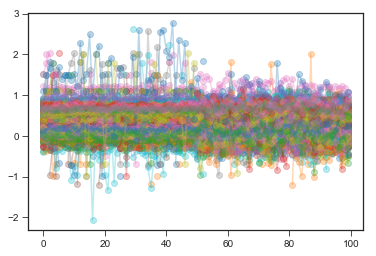

In [83]:
flask = 'A'
time = '0'
coverage = int(1e5)
for bc in range(len(resample_df.index)):
    plt.plot(resample_df[[col for col in resample_df.columns if f'{flask}{time}_{coverage}' in col]].values[bc,:],'-o',alpha=0.3)

In [74]:
1e6

1000000.0

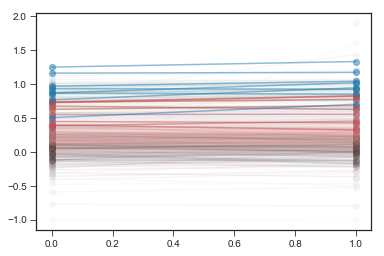

In [142]:
swapped2 = np.asarray(fitnesses2).swapaxes(0,1)
for bc in range(swapped2.shape[0]):
    if data['barcode'].values[bc] > 9000100:
        plt.plot(swapped2[bc],'o-',color=mutant_colorset[genes[bc]],alpha=0.5)
    elif data['barcode'].values[bc] > 9000000:
        plt.plot(swapped2[bc],'o-',color='r',alpha=0.5)
    else:
        plt.plot(swapped2[bc],'o-',color=mutant_colorset[genes[bc]],alpha=0.05)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice.
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Degrees of freedom <= 0 for slice.
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Degrees of freedom <= 0 for slice.
  


Text(0,0.5,'Variance Across 2 Resamples')

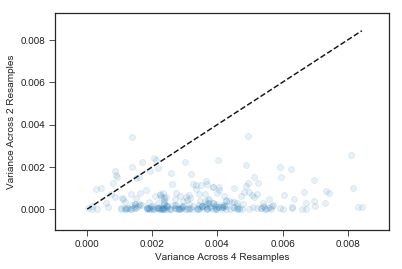

In [140]:
reads = down_samples[0]

coverage_cutoff = 1000
cutoff_indices = np.where(np.all(reads>coverage_cutoff,axis=1))[0]

plt.scatter(np.nanvar(swapped,axis=1)[cutoff_indices],np.nanvar(swapped2,axis=1)[cutoff_indices],alpha=0.1)
bigmin = min([min(np.nanvar(swapped,axis=1)[cutoff_indices]),min(np.nanvar(swapped2,axis=1)[cutoff_indices])])
bigmax = max([max(np.nanvar(swapped,axis=1)[cutoff_indices]),max(np.nanvar(swapped2,axis=1)[cutoff_indices])])
plt.plot([bigmin,bigmax],[bigmin,bigmax],'k--')
plt.xlim(-0.001,bigmax*1.1)
plt.ylim(-0.001,bigmax*1.1)
plt.xlabel('Variance Across 4 Resamples')
plt.ylabel('Variance Across 2 Resamples')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Degrees of freedom <= 0 for slice.
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


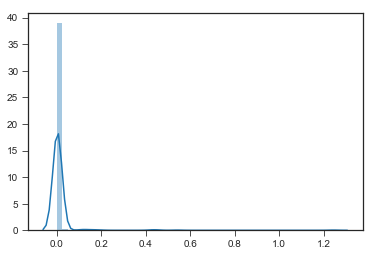

In [120]:
def sumPairs(arr, n): 
  
    # final result 
    sum = 0
    for i in range(n - 1, -1, -1): 
        sum += i*arr[i] - (n-1-i) * arr[i] 
    return sum